# TODO: update with optimized model hyperparameters

this notebook will have clean functions that can be run on all course datasets
- run final models show the optimized output metrics (for NN, also plots accuracy over epochs and NN architecture)
- learning curves
- check them for underfit/overfit by plotting training error vs test error
- calculate precision/recall/accuracy/f1 scores for each
- plot AUC, ROC
- plot of model training time vs f1? idk just a query

In [177]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

import time
from joblib import dump

# Load dataset

In [107]:
dataPath = "../Data/students_mental_health_survey.csv"
df = pd.read_csv(dataPath)

In [108]:
""" Dataset Description """
dataset_shape = df.shape
dataset_info = df.info
missing_vals = df.isnull().sum()
print(f"{"="*15}Dataset Shape{"="*15}\n{dataset_shape}\n\n{"="*15}Data Types and Column Info{"="*15}\n{dataset_info}\n{"="*15}Missing Values{"="*15}\n{missing_vals}\n\n{"="*15}Unique Values by Column{"="*15}\n")

# unique values for each column:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"{column}:{unique_values}")

===============Dataset Shape===============
(7022, 20)

===============Data Types and Column Info===============
<bound method DataFrame.info of       Age            Course  ... Semester_Credit_Load  Residence_Type
0      25            Others  ...                   17       On-Campus
1      24       Engineering  ...                   27       On-Campus
2      19          Business  ...                   15       On-Campus
3      19  Computer Science  ...                   20      Off-Campus
4      18          Business  ...                   23       On-Campus
...   ...               ...  ...                  ...             ...
7017   20               Law  ...                   26      Off-Campus
7018   24           Medical  ...                   15      Off-Campus
7019   26            Others  ...                   17      Off-Campus
7020   24           Medical  ...                   18      Off-Campus
7021   22           Medical  ...                   17     With Family

[7022 rows x 2

# Preprocessing

In [109]:
""" Handling missing values """
numeric_imputer = SimpleImputer(strategy='mean')
df[['CGPA']] = numeric_imputer.fit_transform(df[['CGPA']])

categorical_imputer = SimpleImputer(strategy='most_frequent')
df[['Substance_Use']] = categorical_imputer.fit_transform(df[['Substance_Use']])

missing_vals = df.isnull().sum()
print(f"{"="*15}Missing Values{"="*15}\n{missing_vals}")

===============Missing Values===============
Age                            0
Course                         0
Gender                         0
CGPA                           0
Stress_Level                   0
Depression_Score               0
Anxiety_Score                  0
Sleep_Quality                  0
Physical_Activity              0
Diet_Quality                   0
Social_Support                 0
Relationship_Status            0
Substance_Use                  0
Counseling_Service_Use         0
Family_History                 0
Chronic_Illness                0
Financial_Stress               0
Extracurricular_Involvement    0
Semester_Credit_Load           0
Residence_Type                 0
dtype: int64


In [110]:
""" Label Encoding """
DEPRESSION_THRESHOLD = 3
df['Depression_Score'] = df['Depression_Score'].apply(lambda x: 1 if x > DEPRESSION_THRESHOLD else 0)

mod_low_high_cols = ['Physical_Activity', 'Social_Support', 'Extracurricular_Involvement']
mod_low_high_map = {'Low': 0, 'Moderate': 0.5, 'High': 1}
for column in mod_low_high_cols:
    df[column] = df[column].map(mod_low_high_map)

yes_no_cols = ['Family_History', 'Chronic_Illness']
yes_no_map = {'Yes': 1, 'No': 0}
for column in yes_no_cols:
    df[column] = df[column].map(yes_no_map)

freq_cols = ['Substance_Use', 'Counseling_Service_Use']
freq_map = {'Never': 0, 'Occasionally': 0.5, None:None, 'Frequently': 1}
for column in freq_cols:
    df[column] = df[column].map(freq_map)

good_poor_avg_cols = ['Sleep_Quality','Diet_Quality']
good_poor_avg_map = {'Good': 1, 'Poor': 0,'Average':0.5}
for column in good_poor_avg_cols:
    df[column] = df[column].map(good_poor_avg_map)

gender_map = {'Male': 1, 'Female': 0}
df['Gender'] = df['Gender'].map(gender_map)

relationship_map = {'Married': 1, 'Single': 0, 'In a Relationship':0.5}
df['Relationship_Status'] = df['Relationship_Status'].map(relationship_map)

residence_map = {'On-Campus': 0, 'Off-Campus': 0.5, 'With Family': 1}
df['Residence_Type'] = df['Residence_Type'].map(residence_map)

print(f"Unique Values by Column{"="*15}\n")

# unique values for each column:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"{column}:{unique_values}")

Unique Values by Column===============

Age:[25 24 19 18 21 23 28 22 27 20 31 26 35 30 32 29 34 33]
Course:['Others' 'Engineering' 'Business' 'Computer Science' 'Medical' 'Law']
Gender:[1 0]
CGPA:[3.56       2.44       3.74       3.65       3.4        3.35
 3.8        3.05       3.49126961 3.19       3.26       3.2
 3.61       3.85       3.46       3.43       3.38       3.5
 3.6        3.08       3.88       3.21       3.62       3.16
 3.71       3.48       3.27       3.41       3.22       3.33
 3.01       3.97       4.         3.63       2.99       3.11
 3.02       3.66       3.09       3.12       3.82       3.23
 3.7        2.95       3.73       3.64       3.79       3.59
 3.34       3.87       3.24       3.44       3.1        3.25
 3.53       3.         3.29       2.98       3.04       3.51
 3.75       3.86       3.78       3.77       3.72       3.45
 3.06       3.84       3.92       3.28       2.86       3.37
 3.54       3.31       3.94       3.9        3.52       3.32
 3.14       3

# EDA

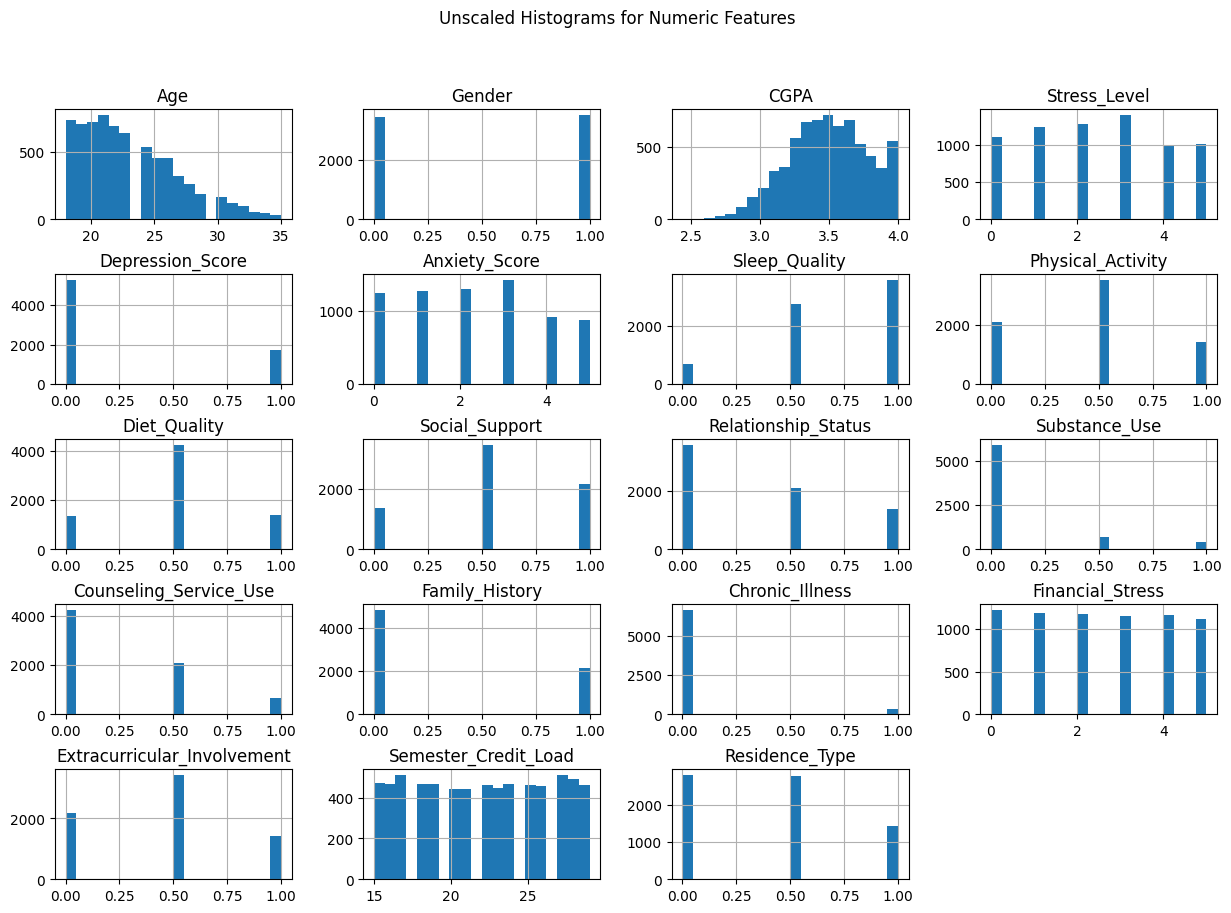

In [80]:
all_numeric_cols =['Age', 'Gender', 'CGPA', 'Stress_Level', 'Depression_Score', 'Anxiety_Score', 'Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Social_Support', 'Relationship_Status', 'Substance_Use', 'Counseling_Service_Use', 'Family_History', 'Chronic_Illness', 'Financial_Stress', 'Extracurricular_Involvement', 'Semester_Credit_Load', 'Residence_Type']

df[all_numeric_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle('Unscaled Histograms for Numeric Features')
plt.subplots_adjust(hspace=0.5)
plt.show()

## Scaling

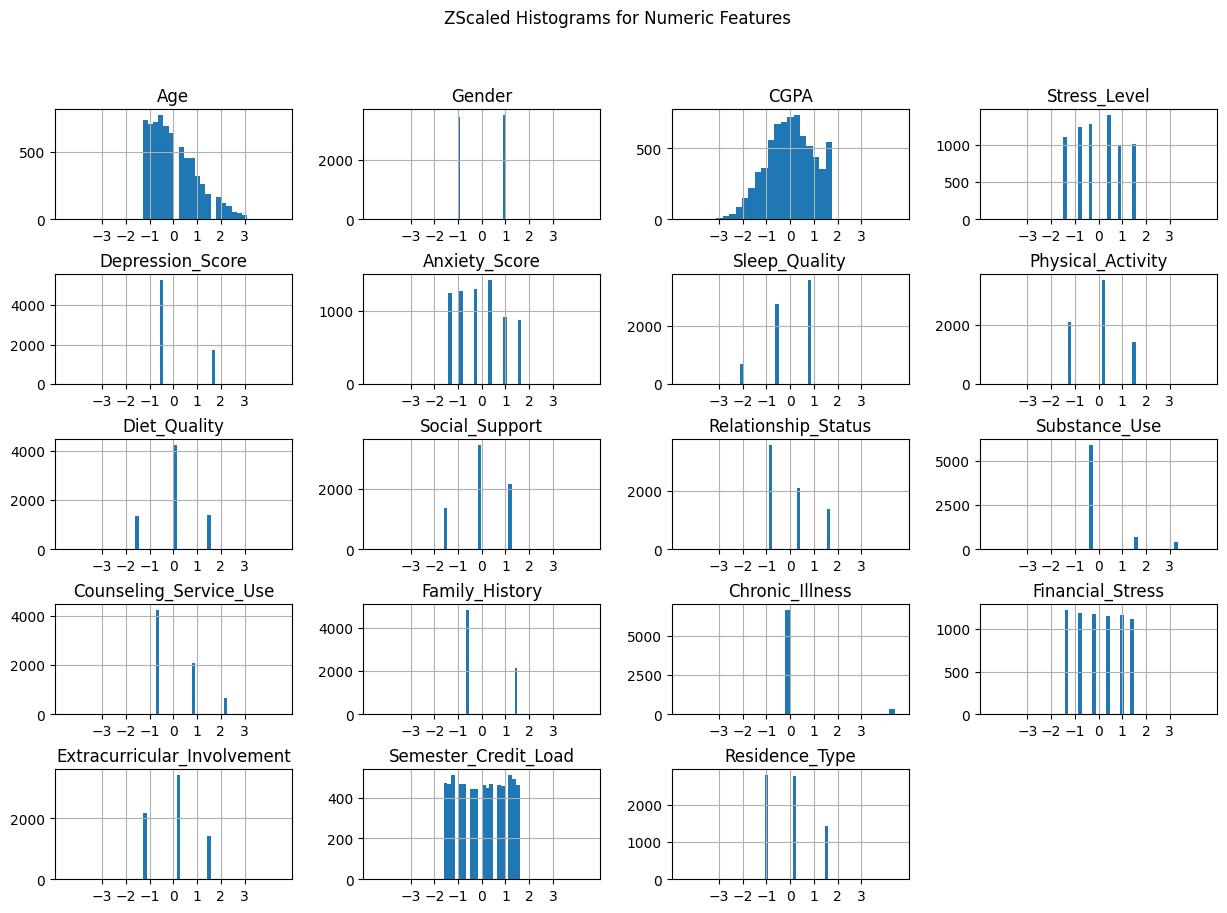

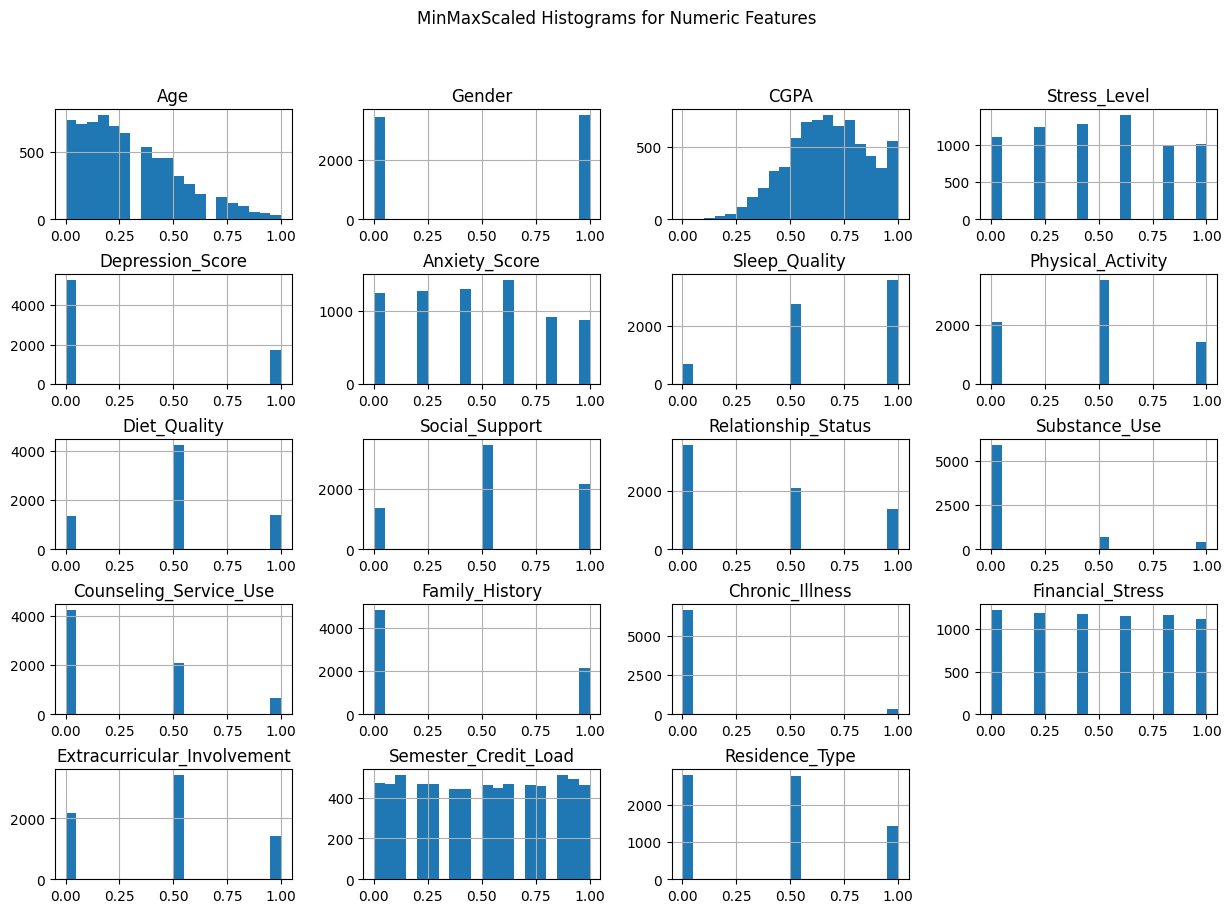

In [81]:
""" Scaling: Z-scale and MinMax"""
Zscaler = StandardScaler()
df_Zscaled = df.copy()
df_Zscaled[all_numeric_cols] = Zscaler.fit_transform(df[all_numeric_cols])
# plotting
axes = df_Zscaled.hist(bins=20, figsize=(15, 10))
for ax in axes.flatten():
    ax.set_xlim([-5, 5])
    ax.set_xticks(np.arange(-3, 4, 1))
plt.suptitle('ZScaled Histograms for Numeric Features')
plt.subplots_adjust(hspace=0.5)
plt.show()


cols_not_minmax_scaled =['Age',  'CGPA', 'Stress_Level', 'Anxiety_Score', 'Financial_Stress', 'Semester_Credit_Load']
minMaxScaler = MinMaxScaler()
df_MinMaxScaled= df.copy()
df_MinMaxScaled[cols_not_minmax_scaled] = minMaxScaler.fit_transform(df[cols_not_minmax_scaled])
# plotting
df_MinMaxScaled.hist(bins=20, figsize=(15, 10))
plt.suptitle('MinMaxScaled Histograms for Numeric Features')
plt.subplots_adjust(hspace=0.5)
plt.show()

## Box Plots

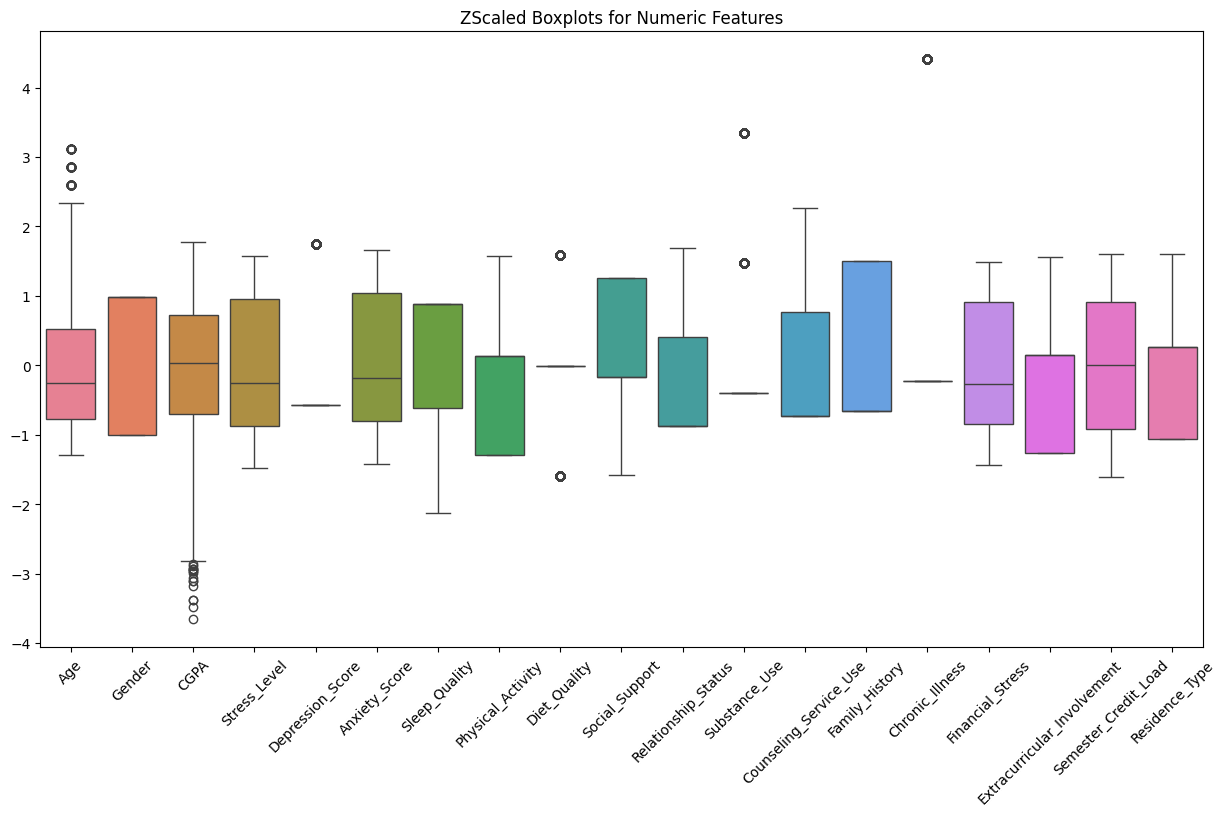

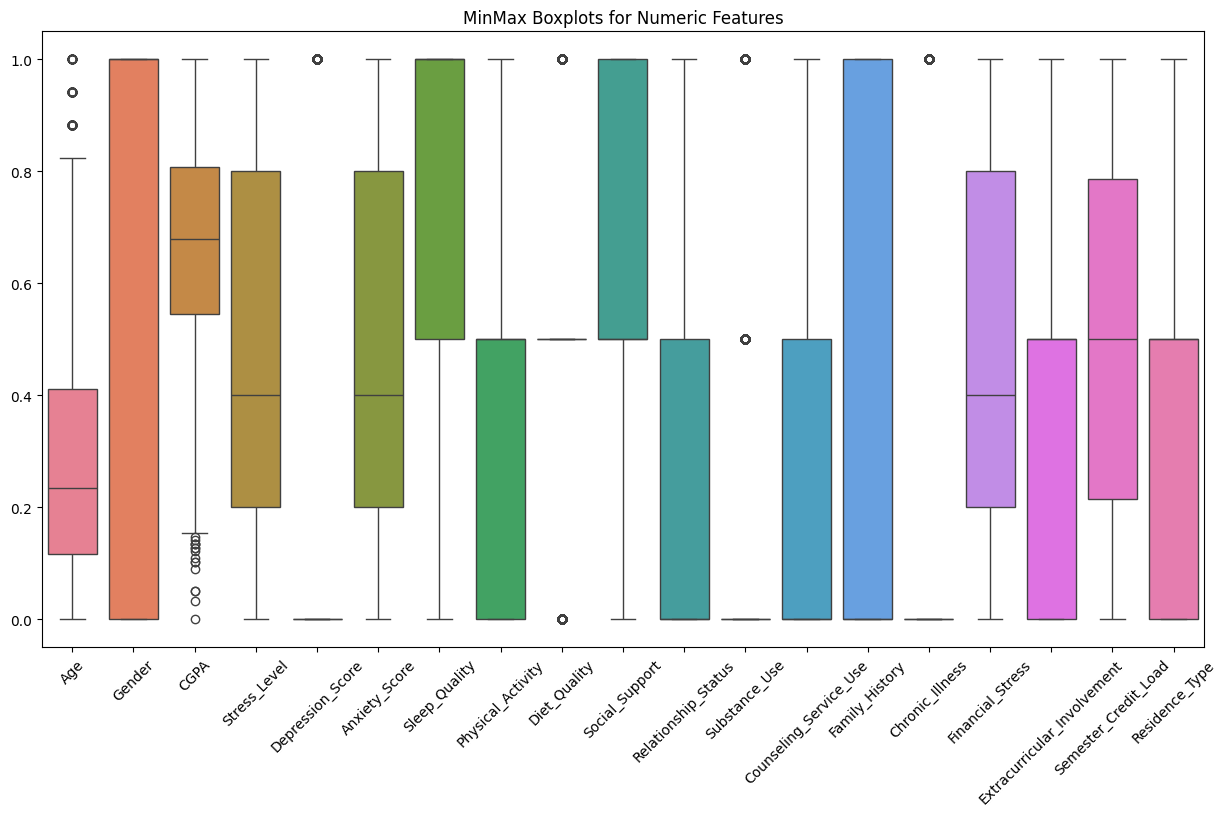

In [82]:
# Z_Scaled
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_Zscaled[all_numeric_cols])
plt.title('ZScaled Boxplots for Numeric Features')
plt.xticks(rotation=45)
plt.show()

# MinMax
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_MinMaxScaled[all_numeric_cols])
plt.title('MinMax Boxplots for Numeric Features')
plt.xticks(rotation=45)
plt.show()

## Correlation Matrices

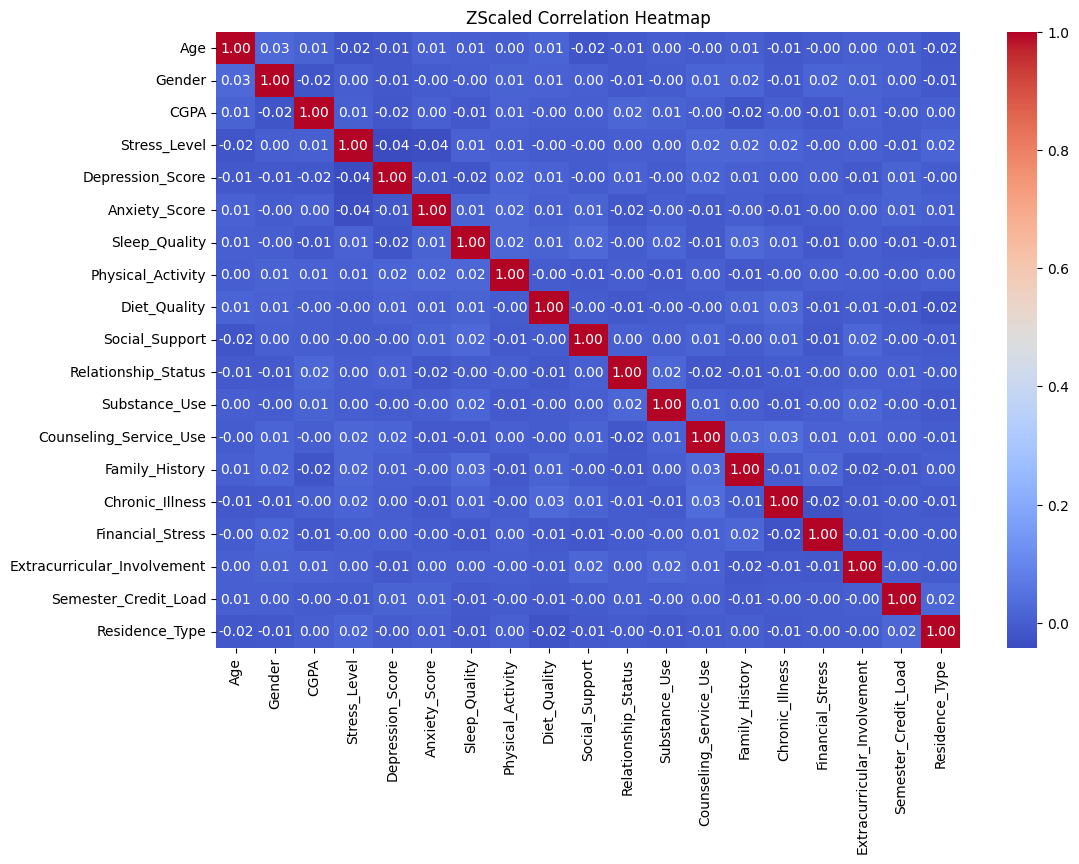

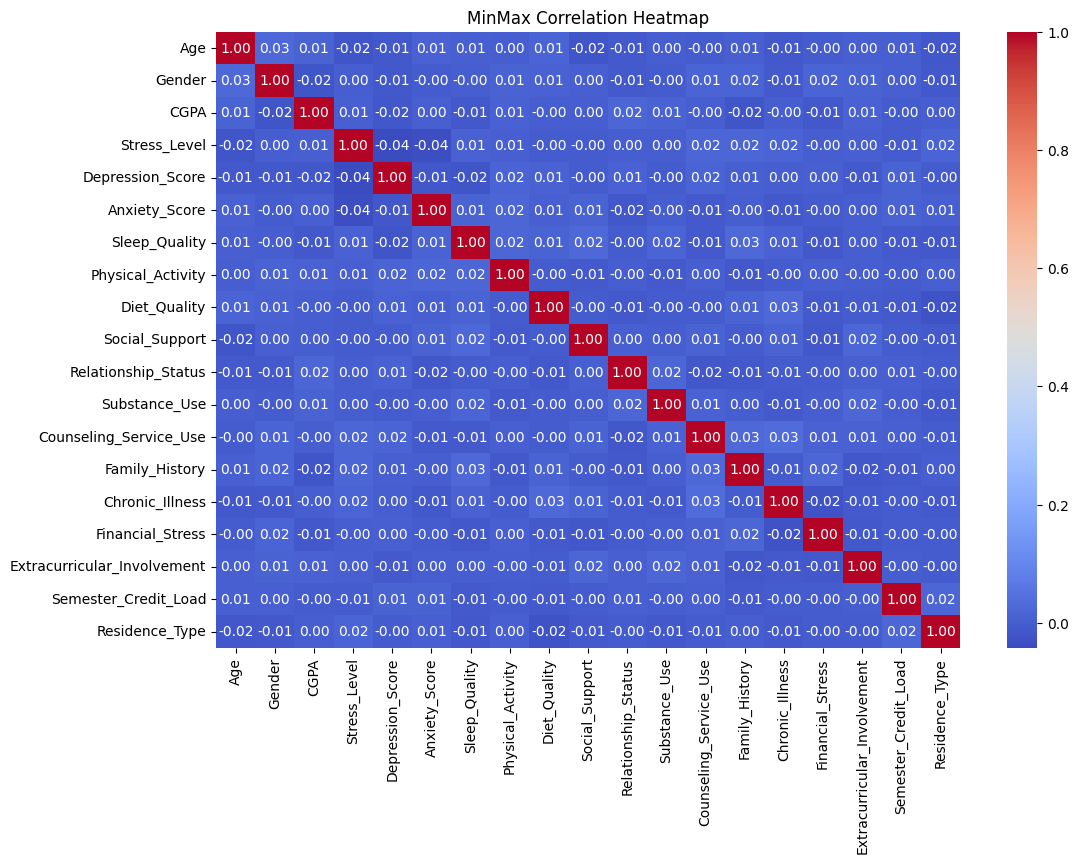

In [83]:
# Z_Scaled
plt.figure(figsize=(12, 8))
correlation_matrix = df_Zscaled[all_numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('ZScaled Correlation Heatmap')
plt.show()

# MinMax
plt.figure(figsize=(12, 8))
correlation_matrix = df_MinMaxScaled[all_numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('MinMax Correlation Heatmap')
plt.show()

## Outlier Detection

In [84]:
def calculate_outliers(df, column_name, remove=False):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    
    if(remove):
        return len(outliers), df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return len(outliers), df

In [85]:
num_age_outliers, _ = calculate_outliers(df_Zscaled, 'Age', False)
print("Number of Age outliers:", num_age_outliers)
num_cgpa_outliers, _ = calculate_outliers(df_Zscaled, 'CGPA', False)
print("Number of CGPA outliers:", num_cgpa_outliers)

Number of Age outliers: 131
Number of CGPA outliers: 16


# Export and save cleaned data

In [144]:
for course in df['Course'].unique():
    course_df = df[df['Course'] == course]
    course_df.to_csv(f'../Data/final/clean_df_{course}.csv', index=False)

# Feature Selection

## tSNE

In [87]:
raw_df = pd.read_csv("../Data/clean_df_main.csv")

course_map = {
    'business': 0,
    'engineering': 1,
    'law': 2,
    'medical': 3,
    'others': 4,
    'compsci': 5
}
raw_df['Course'] = raw_df['Course'].map(course_map)
df = raw_df.drop(['Course'], axis=1)

In [88]:
X = df.drop(['Depression_Score'], axis=1)
y = df['Depression_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=13, test_size=0.25, shuffle=True
)

Scenario 1 - Number of components for 95% variance explained: 18


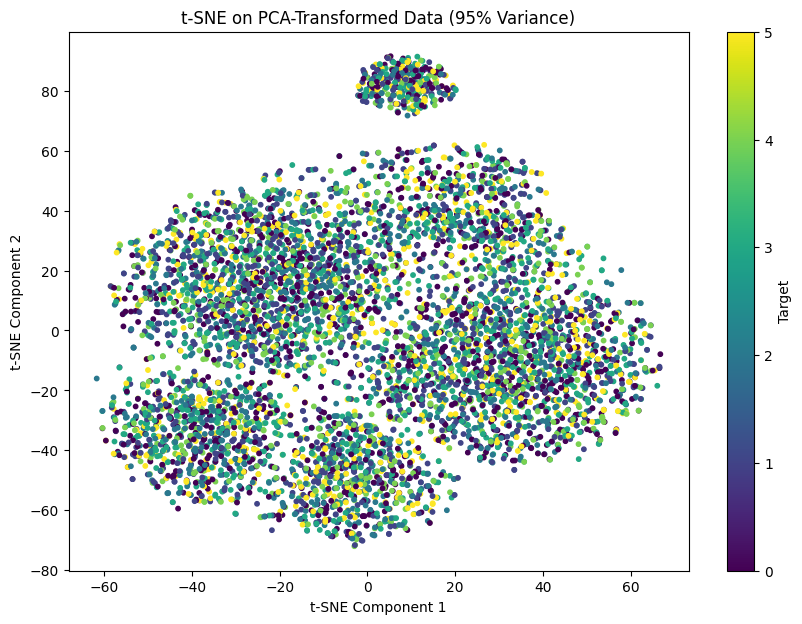

Scenario 2 - PCA with 5 components:
        PC1       PC2       PC3       PC4       PC5
0  0.178877 -0.020894 -1.581074  1.155073  1.198459
1  0.401841 -1.148668  1.433366  0.072223  1.582879
2  0.078813  1.507753 -0.378902  0.825023 -0.016466
3  0.745699  2.988602 -2.418671 -1.132326  0.189275
4  0.380287 -0.382985 -0.765506 -1.033182 -0.259586


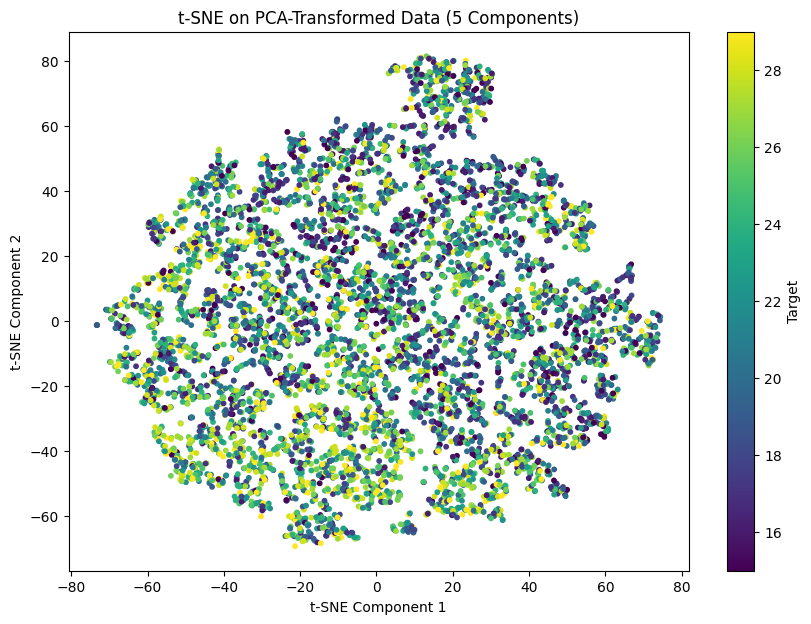

In [ ]:
# Normalize the data
X_scaled = Zscaler.fit_transform(X)

# Scenario 1: PCA with 95% Variance Explained
pca_95 = PCA(n_components=0.95)
X_pca_95 = pca_95.fit_transform(X_scaled)

# Check the number of components selected
print(f"Scenario 1 - Number of components for 95% variance explained: {pca_95.n_components_}")

# Run t-SNE on PCA-transformed data (Scenario 1)
tsne_95 = TSNE(n_components=2, random_state=42)
X_tsne_95 = tsne_95.fit_transform(X_pca_95)

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne_95[:, 0], X_tsne_95[:, 1], c=y, cmap='viridis', s=10)
plt.colorbar(label='Target')
plt.title('t-SNE on PCA-Transformed Data (95% Variance)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Scenario 2: PCA with a Fixed Number of Components (e.g., 5)
pca_fixed = PCA(n_components=5)
X_pca_fixed = pca_fixed.fit_transform(X_scaled)

print("Scenario 2 - PCA with 5 components:")
pca_fixed_df = pd.DataFrame(X_pca_fixed, columns=[f"PC{i+1}" for i in range(5)])
print(pca_fixed_df.head())

# Run t-SNE on PCA-transformed data (Scenario 2)
tsne_fixed = TSNE(n_components=2, random_state=42)
X_tsne_fixed = tsne_fixed.fit_transform(X_pca_fixed)

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne_fixed[:, 0], X_tsne_fixed[:, 1], c=X['Semester_Credit_Load'], cmap='viridis', s=10)
plt.colorbar(label='Target')
plt.title('t-SNE on PCA-Transformed Data (5 Components)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Feature Importance

In [90]:
courses = ['business', 'compsci', 'engineering','law','medical','others']

In [103]:
def get_best_rf_params(X_train, X_test, y_train, y_test, verbose=False):
    best_accuracy_rf = 0
    n_for_best_accuracy_rf = 0
    max_feat_for_best_accuracy_rf = 0

    for n in range(10, 100, 5):
        for max_feat in [1, 'log2', 'sqrt']:
            # Create a Random Forest model
            random_forest = RandomForestClassifier(max_features=max_feat, n_estimators=n, random_state=42)
            random_forest.fit(X_train, y_train)

            # Predict and evaluate
            y_pred_rf = random_forest.predict(X_test)
            accuracy_rf = accuracy_score(y_test, y_pred_rf)
            if verbose:
                print(f'Random Forest [n_estimators={n}, max_features={max_feat}] Accuracy: {accuracy_rf:.4f}')

            if accuracy_rf > best_accuracy_rf and accuracy_rf < 1.0:
                best_accuracy_rf = accuracy_rf
                n_for_best_accuracy_rf = n
                max_feat_for_best_accuracy_rf = max_feat
            
    return n_for_best_accuracy_rf, max_feat_for_best_accuracy_rf

def get_importance(X_train, X_test, y_train, y_test, importance_threshold=0.08, importance_verbose=False, params_verbose=False):
    n, max_feat = get_best_rf_params(X_train, X_test, y_train, y_test, params_verbose)
    random_forest = RandomForestClassifier(max_features=max_feat, n_estimators=n, random_state=42)
    random_forest.fit(X_train, y_train)

    y_pred_rf = random_forest.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)

    rf_feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': random_forest.feature_importances_})
    rf_feature_importances_df = rf_feature_importances_df.sort_values('Importance', ascending=False)

    if importance_verbose:
        print()
        print("Accuracy:", accuracy_rf, '\n')
        print("Feature Importance:")
        print(rf_feature_importances_df)

    features = X.columns
    n_features = len(features)

    plt.figure(figsize=(15, 8))
    plt.bar(features, random_forest.feature_importances_)
    plt.plot(features, importance_threshold*np.ones(n_features), 'r--')
    plt.xticks(features, rotation=45)
    plt.title("Importance using Random Forest")
    plt.show()

=============== business ===============

Accuracy: 0.2837209302325581 

Feature Importance:
                        Feature  Importance
2                          CGPA    0.101563
0                           Age    0.095268
16         Semester_Credit_Load    0.091095
4                 Anxiety_Score    0.077144
3                  Stress_Level    0.073354
14             Financial_Stress    0.070987
15  Extracurricular_Involvement    0.053583
6             Physical_Activity    0.051674
7                  Diet_Quality    0.051021
5                 Sleep_Quality    0.050678
17               Residence_Type    0.049740
9           Relationship_Status    0.048464
8                Social_Support    0.046111
11       Counseling_Service_Use    0.040965
10                Substance_Use    0.030862
12               Family_History    0.029003
1                        Gender    0.028766
13              Chronic_Illness    0.009723


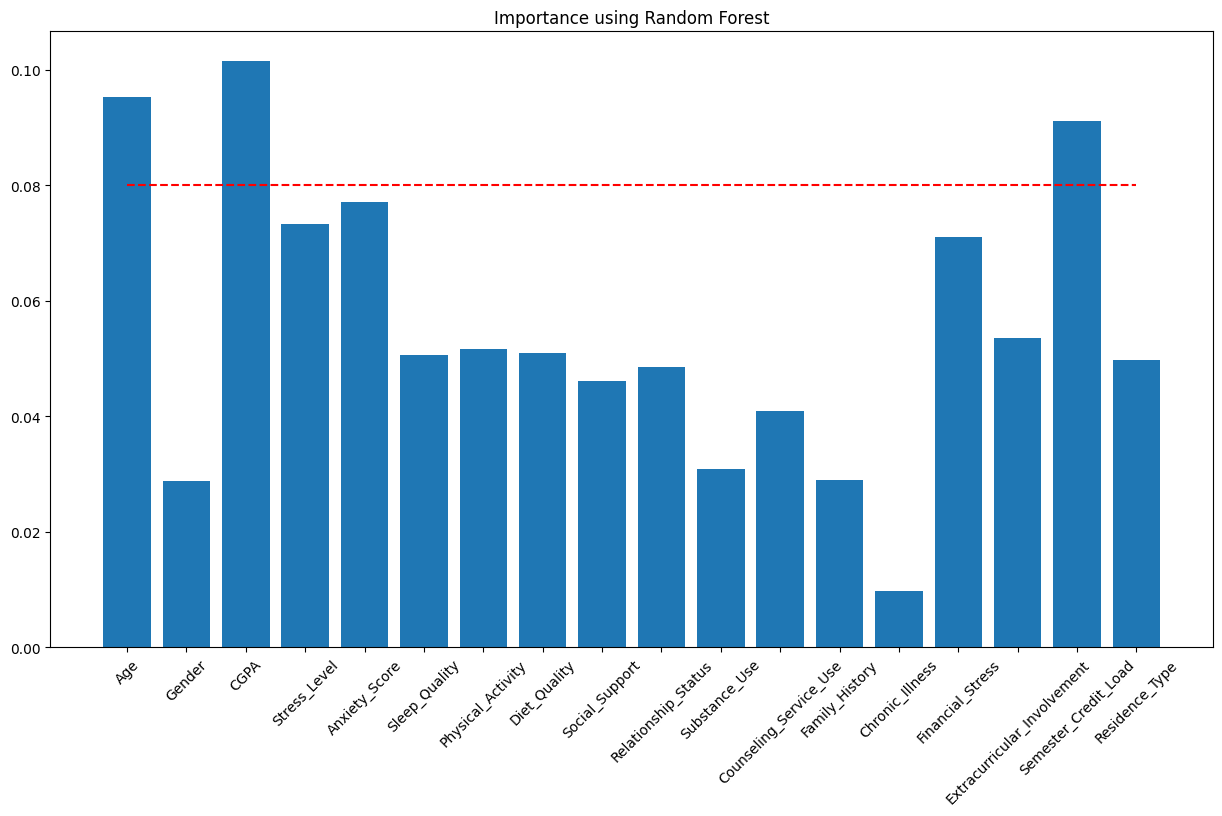

=============== compsci ===============

Accuracy: 0.2671009771986971 

Feature Importance:
                        Feature  Importance
2                          CGPA    0.105167
16         Semester_Credit_Load    0.093458
0                           Age    0.089696
4                 Anxiety_Score    0.076797
14             Financial_Stress    0.074455
3                  Stress_Level    0.073759
15  Extracurricular_Involvement    0.052055
6             Physical_Activity    0.051101
17               Residence_Type    0.050285
8                Social_Support    0.050090
9           Relationship_Status    0.046999
7                  Diet_Quality    0.046364
5                 Sleep_Quality    0.044990
11       Counseling_Service_Use    0.044444
12               Family_History    0.029931
10                Substance_Use    0.029896
1                        Gender    0.029511
13              Chronic_Illness    0.011003


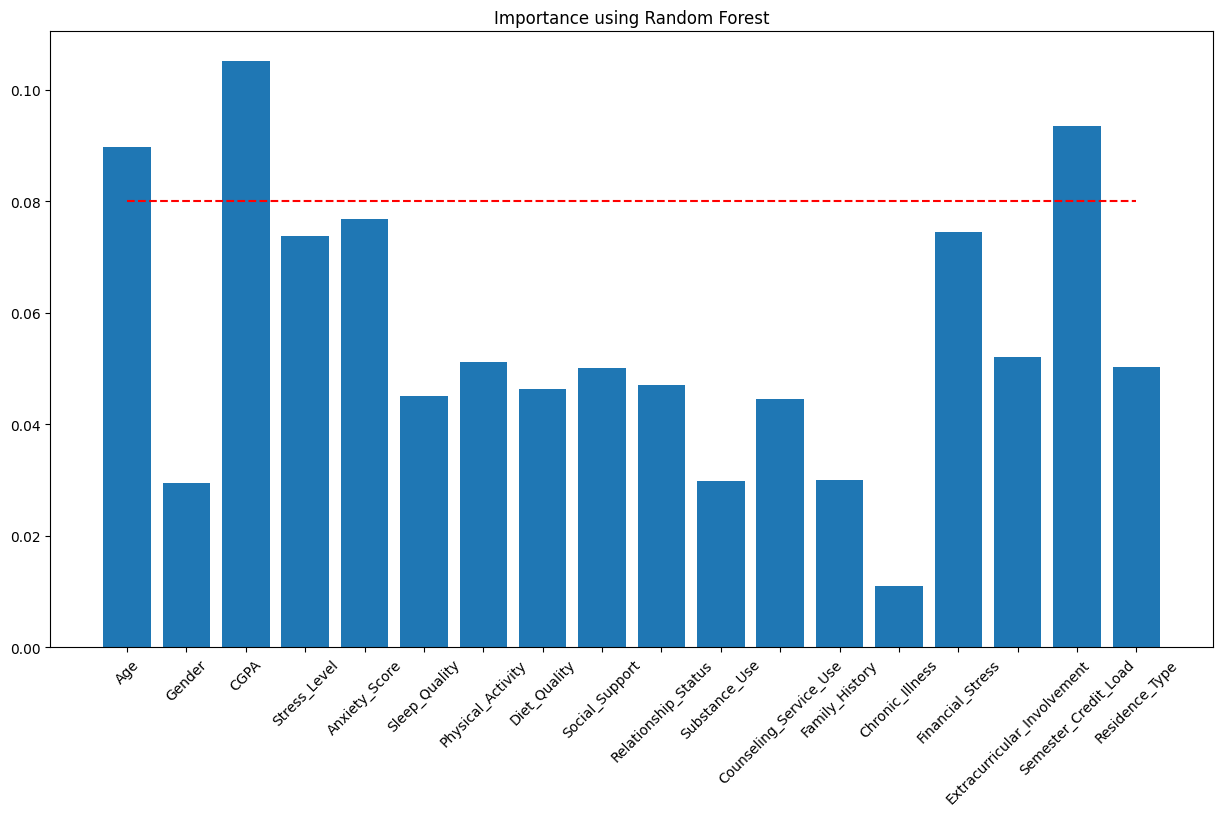

=============== engineering ===============

Accuracy: 0.16510903426791276 

Feature Importance:
                        Feature  Importance
2                          CGPA    0.130702
0                           Age    0.104739
16         Semester_Credit_Load    0.101229
4                 Anxiety_Score    0.076506
14             Financial_Stress    0.074852
3                  Stress_Level    0.072885
6             Physical_Activity    0.047475
15  Extracurricular_Involvement    0.046994
17               Residence_Type    0.045955
9           Relationship_Status    0.045341
7                  Diet_Quality    0.045254
8                Social_Support    0.044298
5                 Sleep_Quality    0.042523
11       Counseling_Service_Use    0.039022
1                        Gender    0.027813
12               Family_History    0.024828
10                Substance_Use    0.021116
13              Chronic_Illness    0.008469


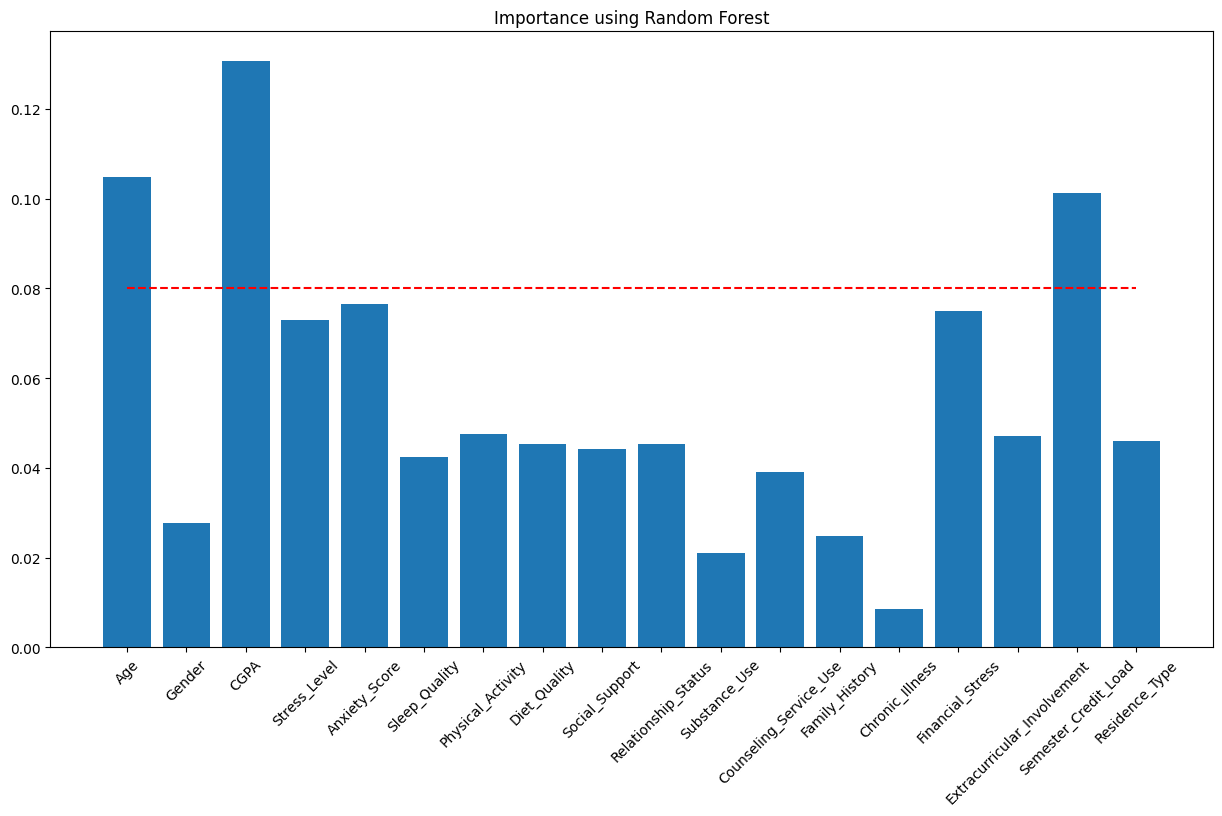

=============== law ===============

Accuracy: 0.2457831325301205 

Feature Importance:
                        Feature  Importance
2                          CGPA    0.129327
0                           Age    0.103763
16         Semester_Credit_Load    0.098045
4                 Anxiety_Score    0.076212
3                  Stress_Level    0.074179
14             Financial_Stress    0.071807
15  Extracurricular_Involvement    0.048344
17               Residence_Type    0.046538
6             Physical_Activity    0.044762
9           Relationship_Status    0.044052
7                  Diet_Quality    0.042653
8                Social_Support    0.042158
5                 Sleep_Quality    0.042077
11       Counseling_Service_Use    0.040333
12               Family_History    0.030398
1                        Gender    0.028565
10                Substance_Use    0.025804
13              Chronic_Illness    0.010981


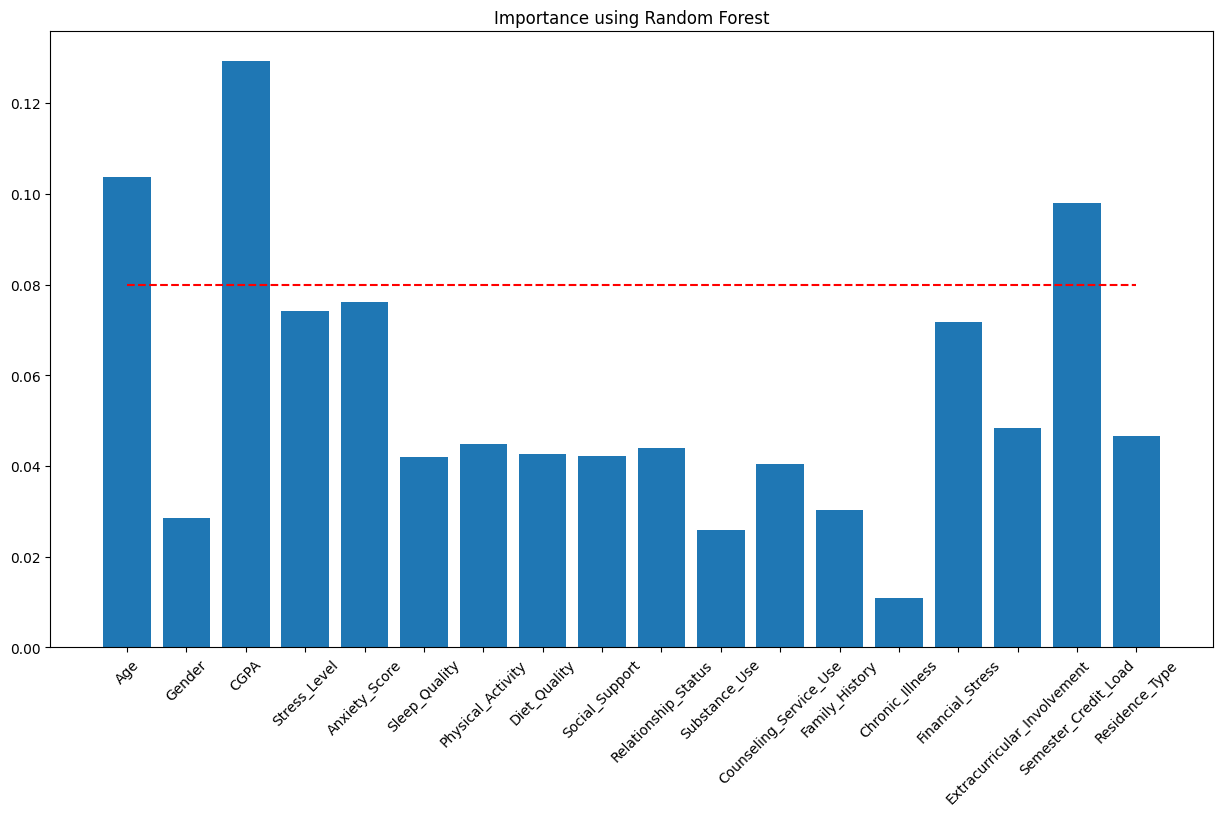

=============== medical ===============

Accuracy: 0.21939586645468998 

Feature Importance:
                        Feature  Importance
2                          CGPA    0.138002
16         Semester_Credit_Load    0.103165
0                           Age    0.101756
14             Financial_Stress    0.073128
4                 Anxiety_Score    0.071149
3                  Stress_Level    0.067791
15  Extracurricular_Involvement    0.048994
17               Residence_Type    0.048096
6             Physical_Activity    0.045977
8                Social_Support    0.045805
9           Relationship_Status    0.044135
11       Counseling_Service_Use    0.040928
7                  Diet_Quality    0.040097
5                 Sleep_Quality    0.039643
1                        Gender    0.031361
12               Family_History    0.027987
10                Substance_Use    0.024579
13              Chronic_Illness    0.007407


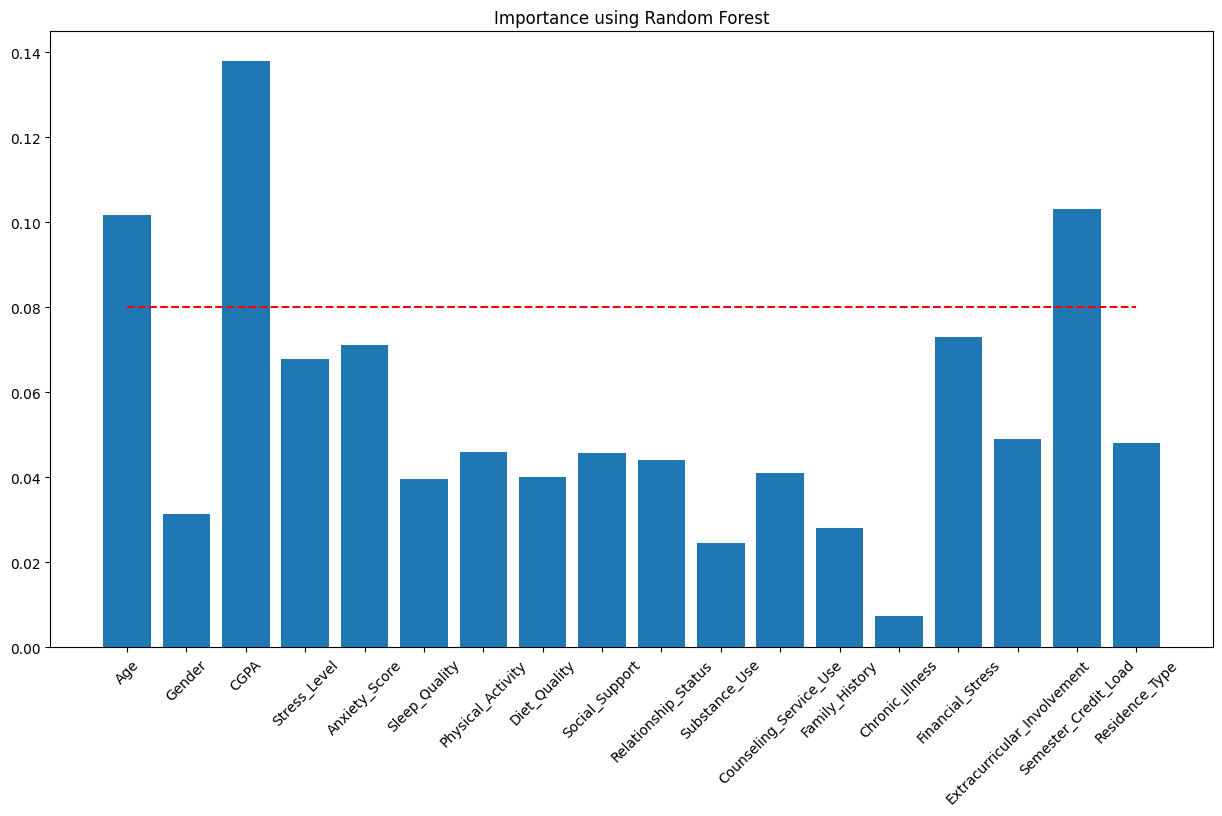

=============== others ===============

Accuracy: 0.25116279069767444 

Feature Importance:
                        Feature  Importance
2                          CGPA    0.099895
16         Semester_Credit_Load    0.093427
0                           Age    0.092846
14             Financial_Stress    0.076409
4                 Anxiety_Score    0.076207
3                  Stress_Level    0.075734
17               Residence_Type    0.052981
15  Extracurricular_Involvement    0.052319
6             Physical_Activity    0.050003
8                Social_Support    0.049373
7                  Diet_Quality    0.047353
5                 Sleep_Quality    0.044655
11       Counseling_Service_Use    0.043818
9           Relationship_Status    0.042944
1                        Gender    0.031175
12               Family_History    0.030517
10                Substance_Use    0.025369
13              Chronic_Illness    0.014974


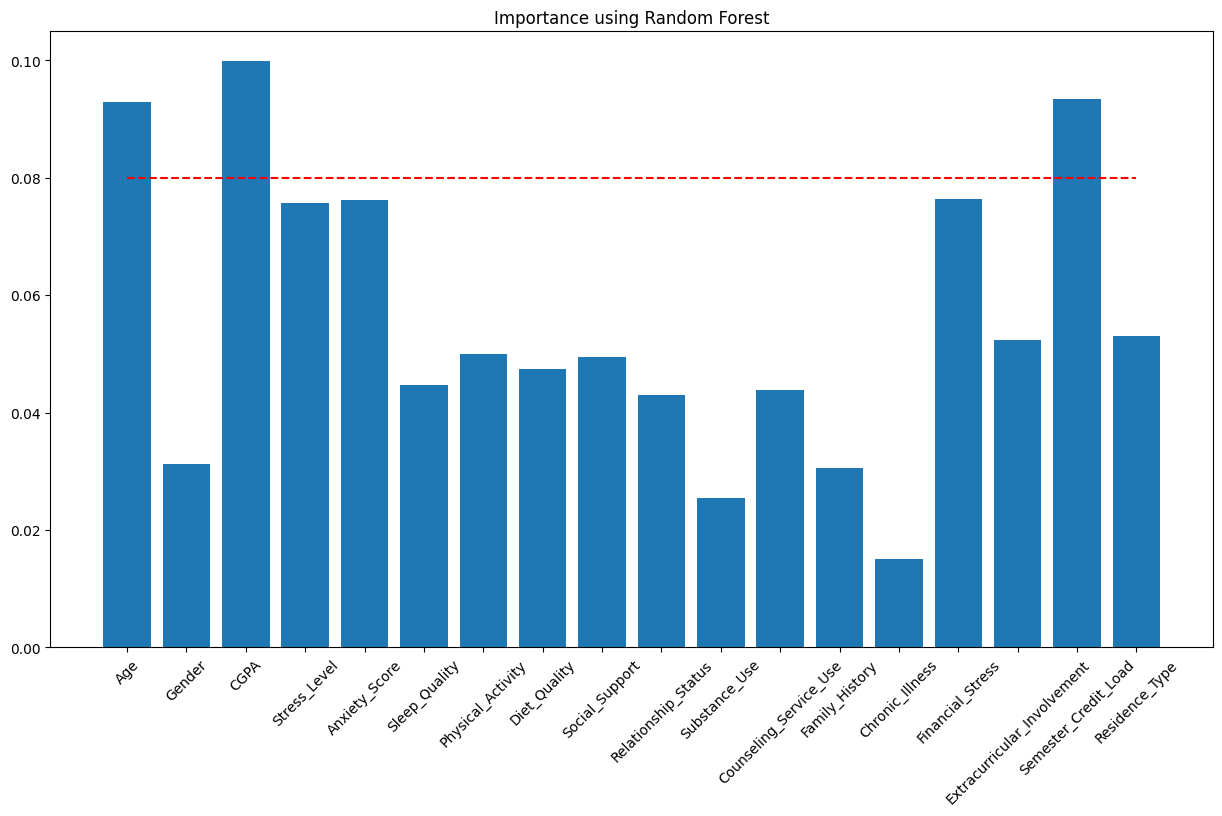

In [104]:
for course in courses:
    print("="*15, course, "="*15)
    data = pd.read_csv(f'../Data/clean_df_{course}.csv')
    data.drop(['Course'], axis=1, inplace=True)

    X = data.drop(['Depression_Score'], axis=1)
    y = data['Depression_Score']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    X_train = minMaxScaler.fit_transform(X_train)
    X_test = minMaxScaler.transform(X_test)

    get_importance(X_train, X_test, y_train, y_test, importance_verbose=True, params_verbose=False)

top 6 features for all datasets: ['Age', 'CGPA', 'Stress_Level', 'Depression_Score', 'Anxiety_Score', 'Financial_Stress', 'Semester_Credit_Load']

# Pair plots

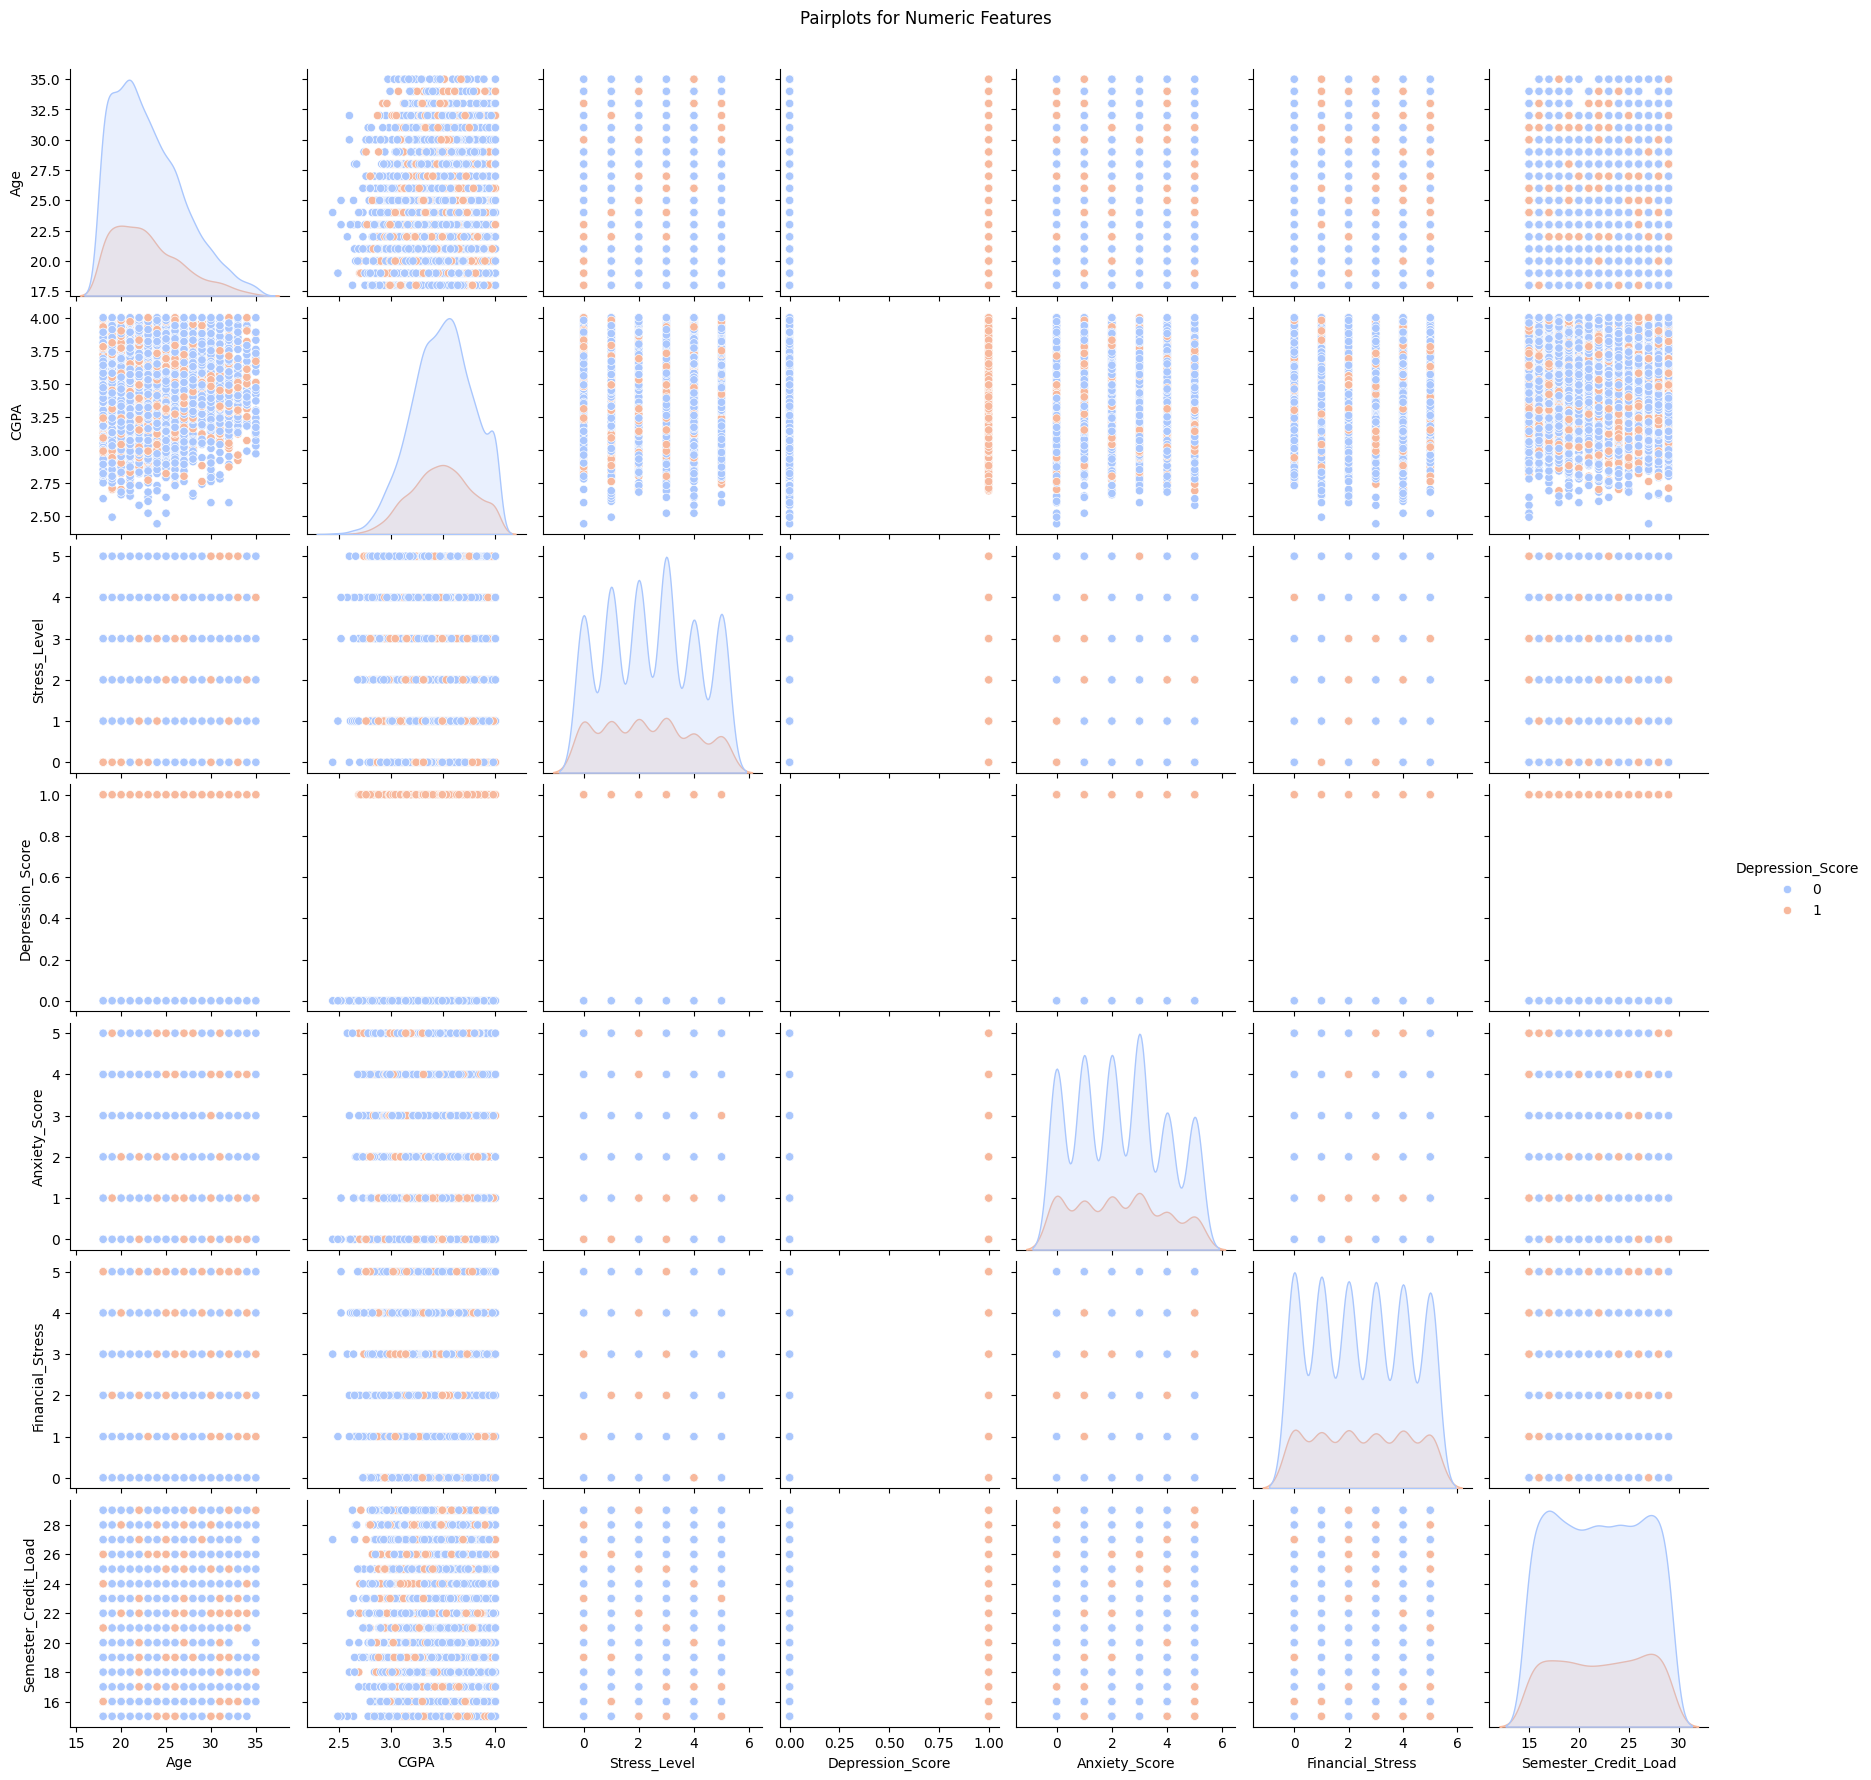

In [114]:
columns_to_include = ['Age', 'CGPA', 'Stress_Level', 'Depression_Score', 'Anxiety_Score', 'Financial_Stress', 'Semester_Credit_Load']

sns.pairplot(df, 
             vars=columns_to_include, 
             hue='Depression_Score', 
             diag_kind='kde', 
             palette='coolwarm')

plt.suptitle("Pairplots for Numeric Features", y=1.02)
plt.show()

# Model Training

In [178]:
Zscaler = StandardScaler()
minMaxScaler = MinMaxScaler()

In [179]:
SCALER_TO_MODELS = {
    'Zscaler': ['KNeighborsClassifier', 'SVC', 'LogisticRegression'],
    'minMaxScaler': ['KerasClassifier', 'RandomForestClassifier', 'GaussianNB']
}

In [180]:
features = ['Age', 'CGPA', 'Semester_Credit_Load']
N_FEATURES = len(features)
DEPRESSION_THRESHOLD = 4

In [181]:
def build_model(num_layers, num_neurons, activation, momentum, reg_method, reg_rate, learning_rate):
    regularizer = l1(reg_rate) if reg_method=='l1' else l2(reg_rate)

    model = Sequential()

    # Input layer
    model.add(Input((N_FEATURES,)))
    # Hidden layers
    for _ in range(num_layers):
        model.add(Dense(num_neurons, activation=activation, kernel_regularizer=regularizer))
    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    loss_string = 'binary_crossentropy'
    model.compile(loss=loss_string, optimizer=optimizer, metrics=['accuracy'])
    return model

In [182]:
def fit_all_models(X_train, y_train, X_test, y_test, param_dict):
    models = ['KNeighborsClassifier', 'SVC', 'LogisticRegression','KerasClassifier', 'RandomForestClassifier', 'GaussianNB']

    results = []
   
    # Dictionary to store performance metrics
    training_times = []
    train_accuracies = []
    test_accuracies = []
    roc_plot, roc_ax = plt.subplots(figsize=(10, 6))

    # Train and evaluate each model
    for model_name in models:
        # init
        model = globals()[model_name](**param_dict[model_name])

        model_data = {
        'model': model,
        }
        
        if model_name in SCALER_TO_MODELS['Zscaler']: 
            model_data['scaler'] = Zscaler
            X_train = Zscaler.fit_transform(X_train)
            X_test = Zscaler.transform(X_test)
        else:
            model_data['scaler'] = minMaxScaler
            X_train = minMaxScaler.fit_transform(X_train)
            X_test = minMaxScaler.transform(X_test)

        # Fit the model
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        training_times.append(training_time)
        
        # Get predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Compute accuracy for both training and testing
        train_acc = accuracy_score(y_train, y_train_pred)
        train_accuracies.append(train_acc)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_accuracies.append(test_acc)
        
        # Confusion matrix
        model_data['conf_matrix']= confusion_matrix(y_test, y_test_pred)

        # Classification report
        model_data['classification_report'] = classification_report(y_test, y_test_pred, target_names=["Not Depressed", "Depressed"])

        # ROC and AUC
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
        model_data['roc_auc'] = roc_auc

        results.append(model_data)

    fit_check_plot, ax = plt.subplots(figsize=(10, 6))
    ax.plot(models, train_accuracies, label='Training Accuracy', marker='o')
    ax.plot(models, test_accuracies, label='Testing Accuracy', marker='o')
    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training Accuracy and Test Accuracy vs models')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

    roc_ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    roc_ax.set_xlim([0.0, 1.0])
    roc_ax.set_ylim([0.0, 1.05])
    roc_ax.set_xlabel('False Positive Rate')
    roc_ax.set_ylabel('True Positive Rate')
    roc_ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    roc_ax.legend(loc='lower right')

    time_v_accuracy_plot, ax = plt.subplots(figsize=(10, 6))
    ax.plot(models, training_times, label='Training Time')
    ax.plot(models, test_accuracies, label='Accuracy')
    ax.set_xlabel('Models')
    ax.set_ylabel('Metric')
    ax.set_title('Training Time vs Accuracy Score')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

    return results, fit_check_plot, time_v_accuracy_plot, roc_plot


In [183]:
def pipeline(course, optimal_params):
    data = pd.read_csv(f'../Data/final/clean_df_{course}.csv')
    data.drop(['Course'], axis=1, inplace=True)

    X = data[features]
    y = data['Depression_Score']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    smote = SMOTE(random_state=8, sampling_strategy=1.0)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    return fit_all_models(X_train, y_train, X_test, y_test, optimal_params)
    

In [184]:
def dump_best_model(course, best_model, scaler):
    # for streamlit
    model_path = f"../Frontend/{best_model.__class__.__name__}_{course}_model.pkl"
    dump(best_model, model_path)
    scaler_path =f"../Frontend/{best_model.__class__.__name__}_{course}_scaler.pkl"
    dump(scaler, scaler_path)

## business

In [185]:
business_params ={
    'KNeighborsClassifier': {
        'algorithm': 'auto', 'leaf_size': 20, 'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 18, 'weights': 'uniform'
        },
    'SVC': {
        'C': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'probability': True
        },
    'LogisticRegression': {
        'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'
    },
    'RandomForestClassifier': {
        'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200
    },
    'GaussianNB': {
        'var_smoothing': 1e-09
    },
    "KerasClassifier": {
        "build_fn": build_model, "epochs": 10, 'batch_size': 32, 'model__activation': 'relu', 'model__learning_rate': 0.001, 'model__momentum': 0.5, 'model__num_layers': 4, 'model__num_neurons': 10, 'model__reg_method': 'l1', 'model__reg_rate': 0.001
    }
}

Epoch 1/10


c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5157 - loss: 0.7824
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4926 - loss: 0.7827
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5034 - loss: 0.7823
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4889 - loss: 0.7829
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4873 - loss: 0.7830
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5009 - loss: 0.7823
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5078 - loss: 0.7822
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5082 - loss: 0.7819
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5125 - loss: 0.7822
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4882 - loss: 0.7824
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

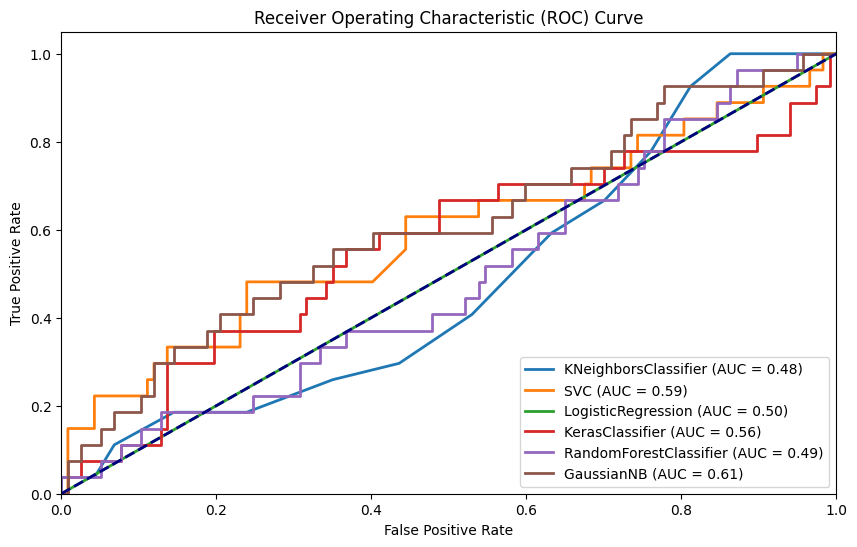

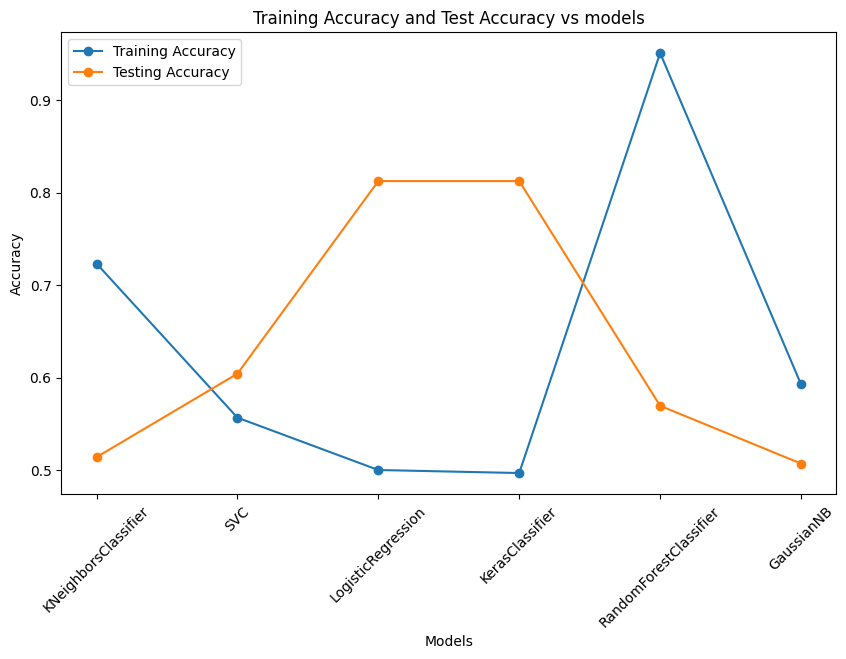

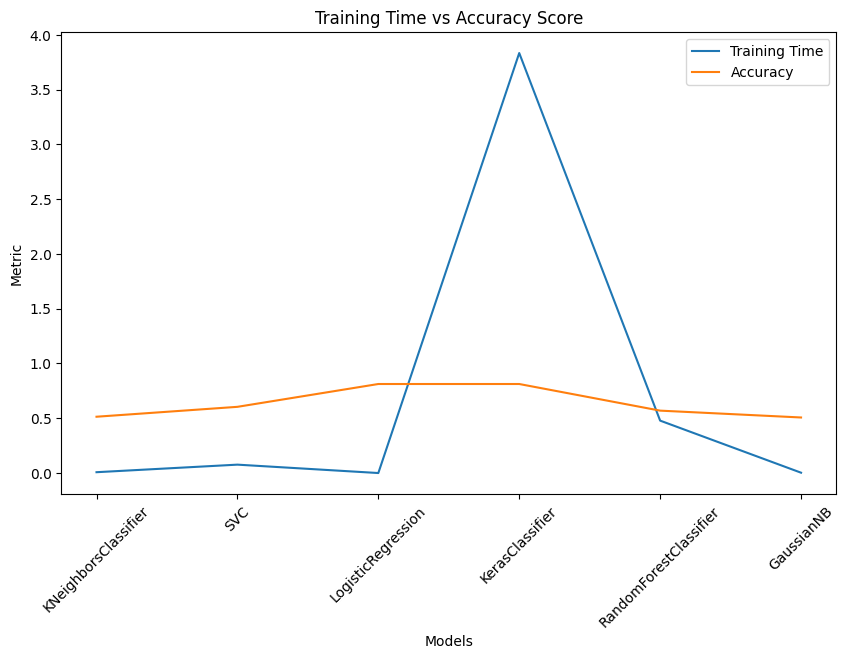

In [186]:
business_results, business_fit_check_plot, business_time_v_accuracy_plot, business_roc_plot = pipeline('business', business_params)

In [187]:
for model_result in business_results:
    print(f"{"="*15}{model_result['model'].__class__.__name__}{"="*15}")
    print(pd.DataFrame(model_result['conf_matrix'], index=["Actual Not Depressed", "Actual Depressed"], columns=["Pred Not Depressed", "Pred Depressed"]))
    print()

for model_result in business_results:
    print(f"{"="*15}{model_result['model'].__class__.__name__}{"="*15}")
    print(model_result['classification_report'])
    print()

===============KNeighborsClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                  66              51
Actual Depressed                      19               8

===============SVC===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                  74              43
Actual Depressed                      14              13

===============LogisticRegression===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                 117               0
Actual Depressed                      27               0

===============KerasClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                 117               0
Actual Depressed                      27               0

===============RandomForestClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed  

best model analysis:
- highest recall for depressed: nb
- highest AUC: nb
- highest precision for depressed: svc
- highest f1 for depressed: nb and svc tied

recommendation: nb

In [206]:
dump_best_model('business', business_results[1]['model'], business_results[1]['scaler'])

# engineering

In [189]:
engineering_params ={
    'KNeighborsClassifier': {
        'algorithm': 'auto', 'leaf_size': 20, 'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 16, 'weights': 'uniform'
        },
    'SVC': {
        'C': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'probability': True
        },
    'LogisticRegression': {
        'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'
    },
    'RandomForestClassifier': {
        'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100
    },
    'GaussianNB': {
        'var_smoothing': 1e-09
    },
    "KerasClassifier": {
        "build_fn": build_model, "epochs": 10, 'batch_size': 32, 'model__activation': 'relu', 'model__learning_rate': 0.001, 'model__momentum': 0.5, 'model__num_layers': 3, 'model__num_neurons': 12, 'model__reg_method': 'l1', 'model__reg_rate': 0.01
    }
}

Epoch 1/10


c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4376 - loss: 1.5214
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4553 - loss: 1.5182
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4370 - loss: 1.5155
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4442 - loss: 1.5127
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4375 - loss: 1.5098
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4457 - loss: 1.5068
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4341 - loss: 1.5041
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4372 - loss: 1.5015
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4348 - loss: 1.4988
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4759 - loss: 1.4953
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


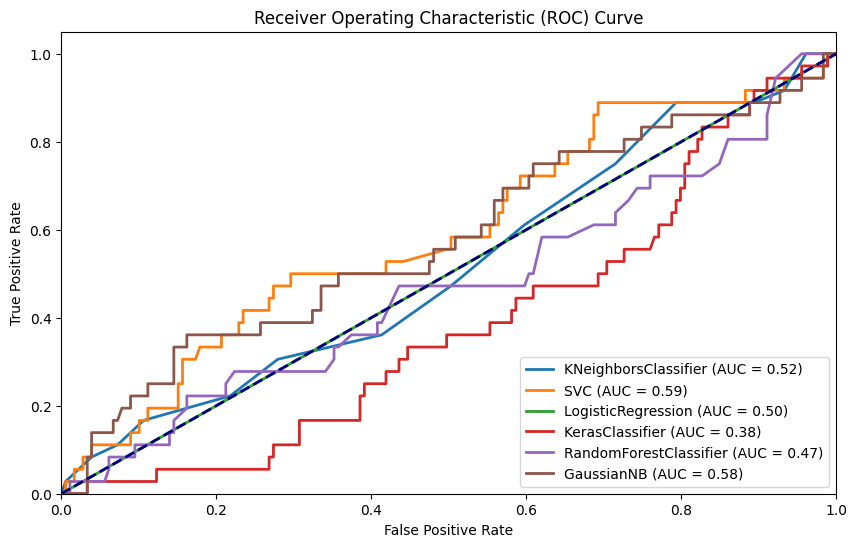

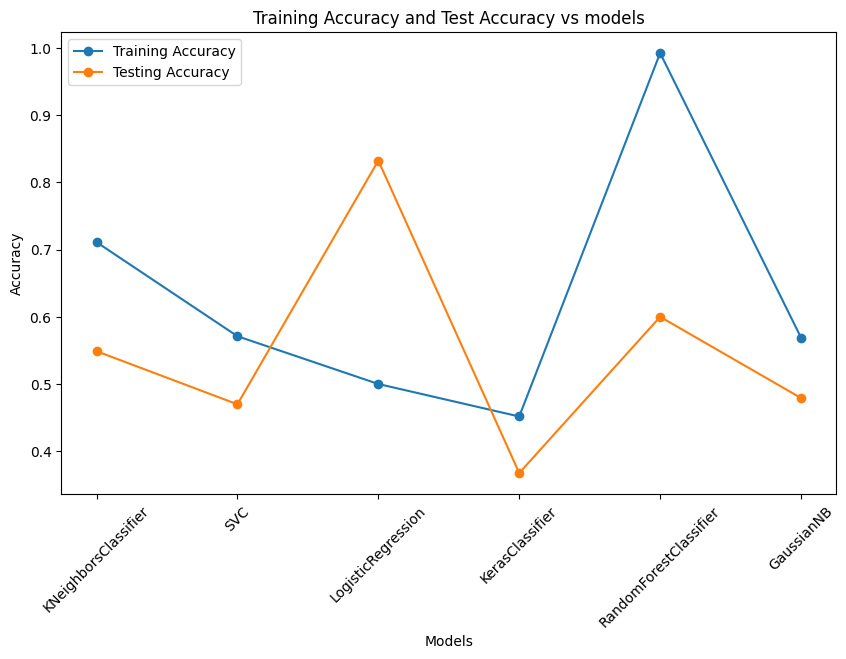

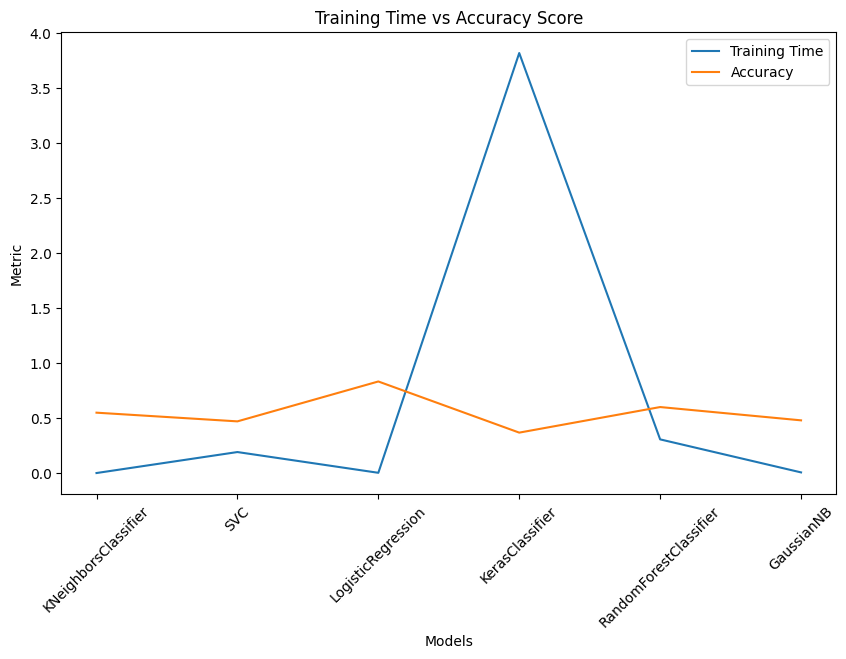

In [190]:
engineering_results, engineering_fit_check_plot, engineering_time_v_accuracy_plot, engineering_roc_plot = pipeline('engineering', engineering_params)

In [191]:
for model_result in engineering_results:
    print(f"{"="*15}{model_result['model'].__class__.__name__}{"="*15}")
    print(pd.DataFrame(model_result['conf_matrix'], index=["Actual Not Depressed", "Actual Depressed"], columns=["Pred Not Depressed", "Pred Depressed"]))
    print()

for model_result in engineering_results:
    print(f"{"="*15}{model_result['model'].__class__.__name__}{"="*15}")
    print(model_result['classification_report'])
    print()

===============KNeighborsClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                 105              74
Actual Depressed                      23              13

===============SVC===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                  79             100
Actual Depressed                      14              22

===============LogisticRegression===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                 179               0
Actual Depressed                      36               0

===============KerasClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                  62             117
Actual Depressed                      19              17

===============RandomForestClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed  

best model analysis:
- highest recall for depressed: svc
- highest AUC: svc
- highest precision for depressed: svc and nb tied
- highest f1 for depressed: svc

recommendation: svc

In [202]:
dump_best_model('engineering', engineering_results[1]['model'], engineering_results[1]['scaler'])

# law

In [193]:
law_params ={
    'KNeighborsClassifier': {
        'algorithm': 'auto', 'leaf_size': 20, 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 14, 'weights': 'uniform'
        },
    'SVC': {
        'C': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'probability': True
        },
    'LogisticRegression': {
        'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'
    },
    'RandomForestClassifier': {
        'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100
    },
    'GaussianNB': {
        'var_smoothing': 1e-09
    },
    "KerasClassifier": {
        "build_fn": build_model, "epochs": 10, 'batch_size': 32, 'model__activation': 'relu', 'model__learning_rate': 0.001, 'model__momentum': 0.5, 'model__num_layers': 3, 'model__num_neurons': 10, 'model__reg_method': 'l2', 'model__reg_rate': 0.001
    }
}

Epoch 1/10


c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5307 - loss: 0.7163
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4983 - loss: 0.7180
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4867 - loss: 0.7182
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5121 - loss: 0.7173
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4978 - loss: 0.7172
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4889 - loss: 0.7181
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4973 - loss: 0.7176
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5037 - loss: 0.7178
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5096 - loss: 0.7172
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4883 - loss: 0.7175
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


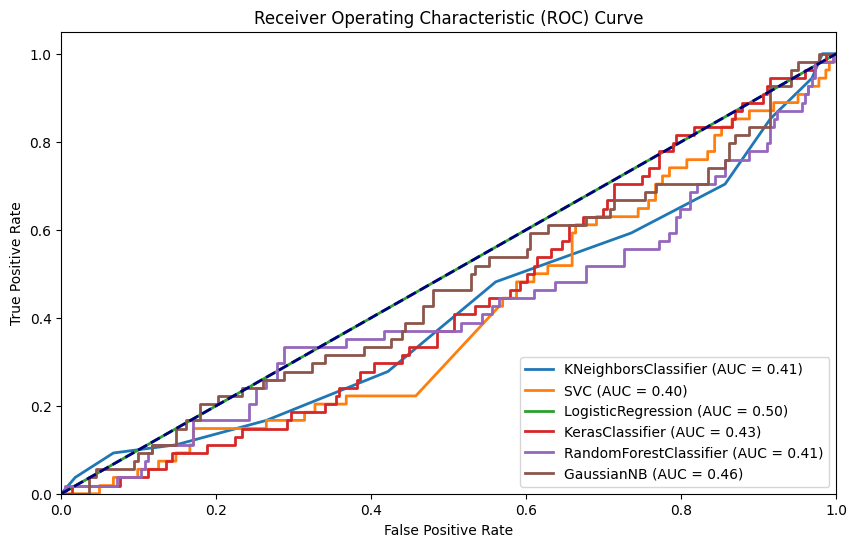

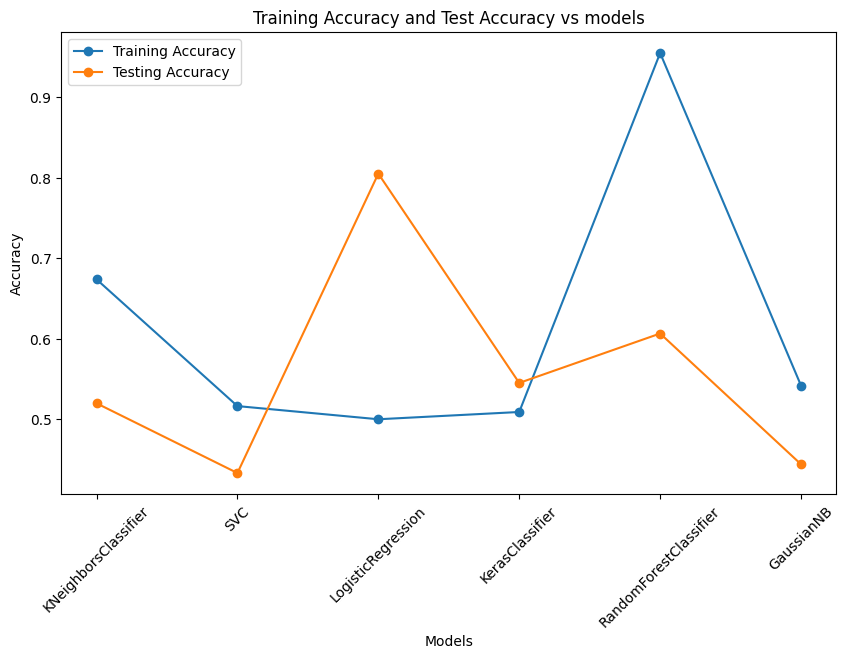

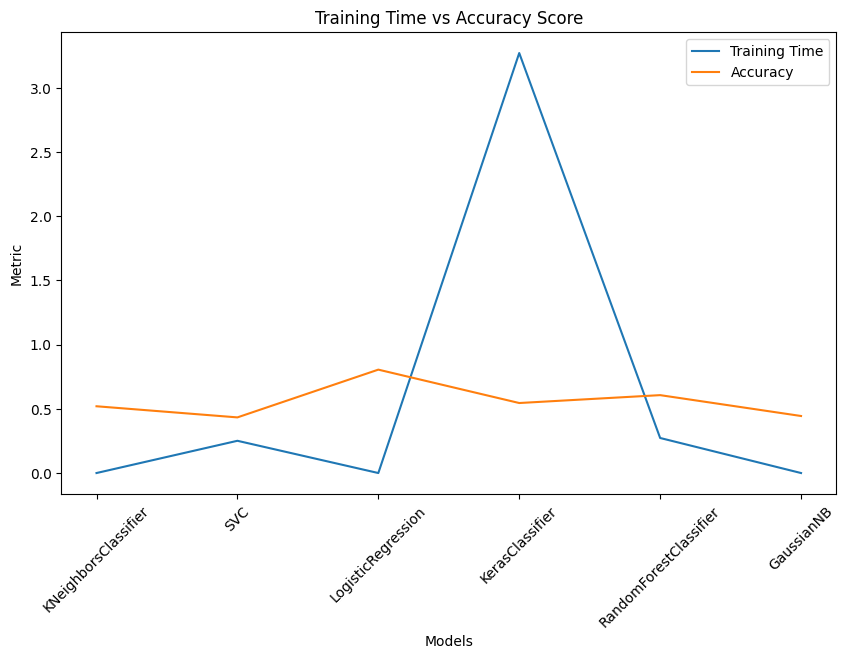

In [194]:
law_results, law_fit_check_plot, law_time_v_accuracy_plot, law_roc_plot = pipeline('law', law_params)

In [203]:
for model_result in law_results:
    print(f"{"="*15}{model_result['model'].__class__.__name__}{"="*15}")
    print(pd.DataFrame(model_result['conf_matrix'], index=["Actual Not Depressed", "Actual Depressed"], columns=["Pred Not Depressed", "Pred Depressed"]))
    print()

for model_result in law_results:
    print(f"{"="*15}{model_result['model'].__class__.__name__}{"="*15}")
    print(model_result['classification_report'])
    print()

===============KNeighborsClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                 129              94
Actual Depressed                      39              15

===============SVC===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                  97             126
Actual Depressed                      31              23

===============LogisticRegression===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                 223               0
Actual Depressed                      54               0

===============KerasClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                 136              87
Actual Depressed                      39              15

===============RandomForestClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed  

best model analysis:
- highest recall for depressed: nb
- highest AUC: lr
- highest precision for depressed: rf
- highest f1 for depressed: nb

recommendation: nb

In [207]:
dump_best_model('law', law_results[-1]['model'], law_results[-1]['scaler'])

# medical

In [195]:
medical_params ={
    'KNeighborsClassifier': {
        'algorithm': 'auto', 'leaf_size': 20, 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 17, 'weights': 'uniform'
        },
    'SVC': {
        'C': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'probability': True
        },
    'LogisticRegression': {
        'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'
    },
    'RandomForestClassifier': {
        'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5,'n_estimators': 200
    },
    'GaussianNB': {
        'var_smoothing': 1e-09
    },
    "KerasClassifier": {
        "build_fn": build_model, "epochs": 10, 'batch_size': 32, 'model__activation': 'relu', 'model__learning_rate': 0.001, 'model__momentum': 0.5, 'model__num_layers': 2, 'model__num_neurons': 8, 'model__reg_method': 'l1', 'model__reg_rate': 0.001
    }
}

Epoch 1/10


c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5084 - loss: 0.7378
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5024 - loss: 0.7368
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4912 - loss: 0.7395
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5109 - loss: 0.7324
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5051 - loss: 0.7308
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5215 - loss: 0.7273
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5227 - loss: 0.7267
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5148 - loss: 0.7261
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5018 - loss: 0.7290
Epoch 10/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4846 - loss: 0.7303
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


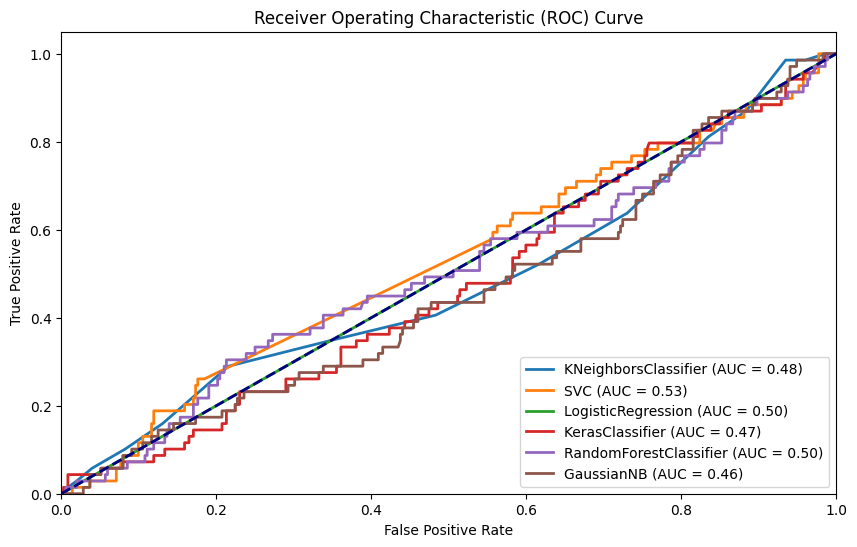

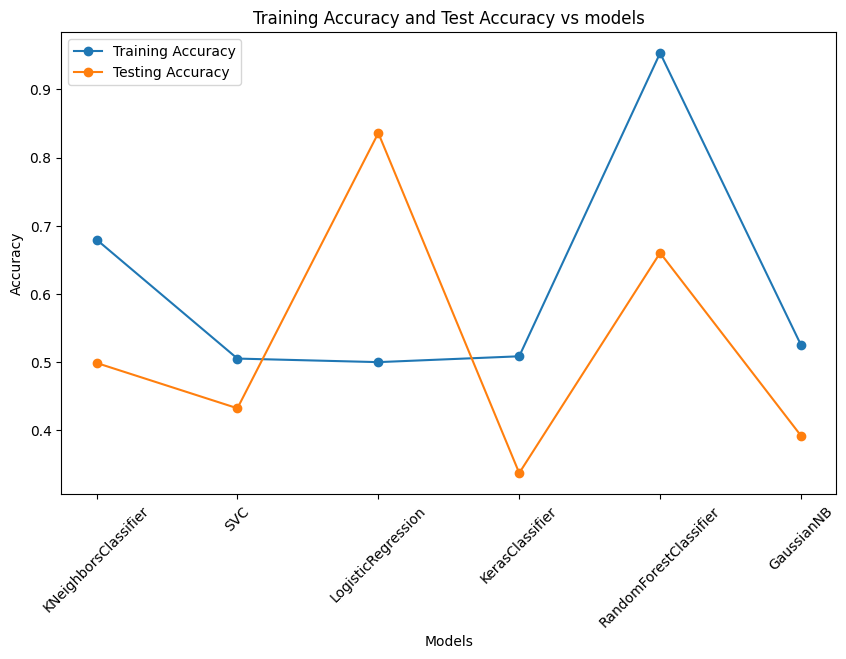

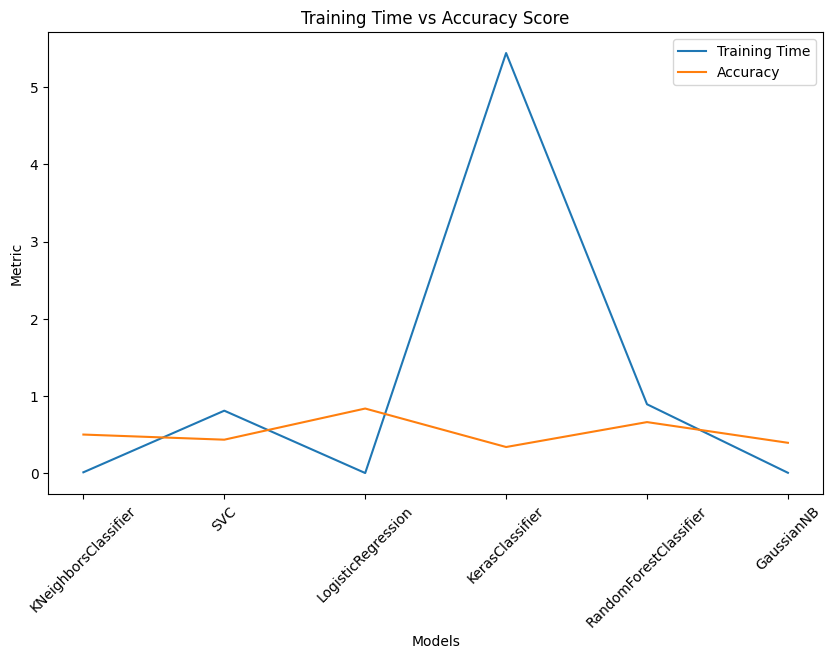

In [196]:
medical_results, medical_fit_check_plot, medical_time_v_accuracy_plot, medical_roc_plot = pipeline('medical', medical_params)

In [205]:
for model_result in medical_results:
    print(f"{"="*15}{model_result['model'].__class__.__name__}{"="*15}")
    print(pd.DataFrame(model_result['conf_matrix'], index=["Actual Not Depressed", "Actual Depressed"], columns=["Pred Not Depressed", "Pred Depressed"]))
    print()

for model_result in medical_results:
    print(f"{"="*15}{model_result['model'].__class__.__name__}{"="*15}")
    print(model_result['classification_report'])
    print()

===============KNeighborsClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                 182             170
Actual Depressed                      41              28

===============SVC===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                 146             206
Actual Depressed                      33              36

===============LogisticRegression===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                 352               0
Actual Depressed                      69               0

===============KerasClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                  91             261
Actual Depressed                      18              51

===============RandomForestClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed  

best model analysis:
- highest recall for depressed: nn
- highest AUC: svc
- highest precision for depressed: rf
- highest f1 for depressed: nn

recommendation: nn

In [208]:
dump_best_model('medical', medical_results[3]['model'], medical_results[3]['scaler'])

# others

In [199]:
others_params ={
    'KNeighborsClassifier': {
        'algorithm': 'auto', 'leaf_size': 20, 'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 12, 'weights': 'uniform'
        },
    'SVC': {
        'C': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'probability': True
        },
    'LogisticRegression': {
        'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'
    },
    'RandomForestClassifier': {
        'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200
    },
    'GaussianNB': {
        'var_smoothing': 1e-09
    },
    "KerasClassifier": {
        "build_fn": build_model, "epochs": 10, 'batch_size': 32, 'model__activation': 'relu', 'model__learning_rate': 0.001, 'model__momentum': 0.5, 'model__num_layers': 3, 'model__num_neurons': 8, 'model__reg_method': 'l1', 'model__reg_rate': 0.01
    }
}

Epoch 1/10


c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4651 - loss: 1.1809
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4911 - loss: 1.1799
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4919 - loss: 1.1791
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4759 - loss: 1.1782
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4858 - loss: 1.1773
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4993 - loss: 1.1764
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4703 - loss: 1.1758
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4752 - loss: 1.1749
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4844 - loss: 1.1738
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4779 - loss: 1.1730
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


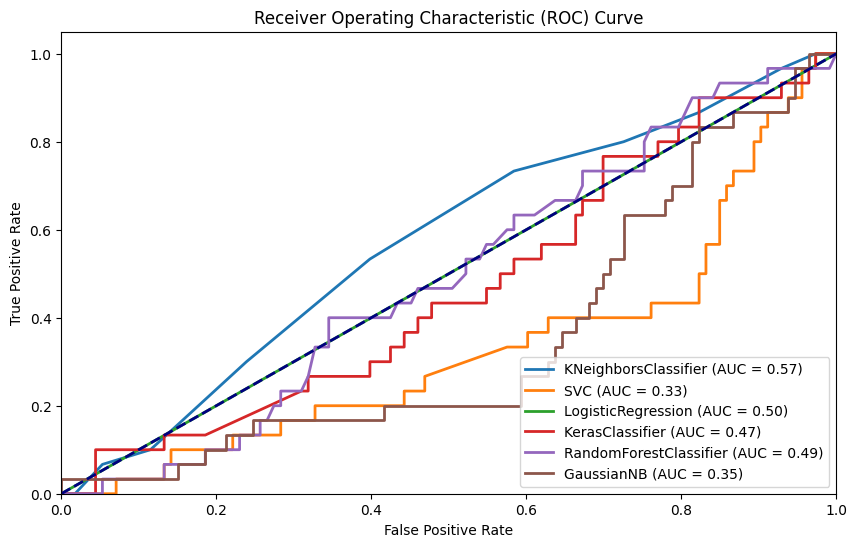

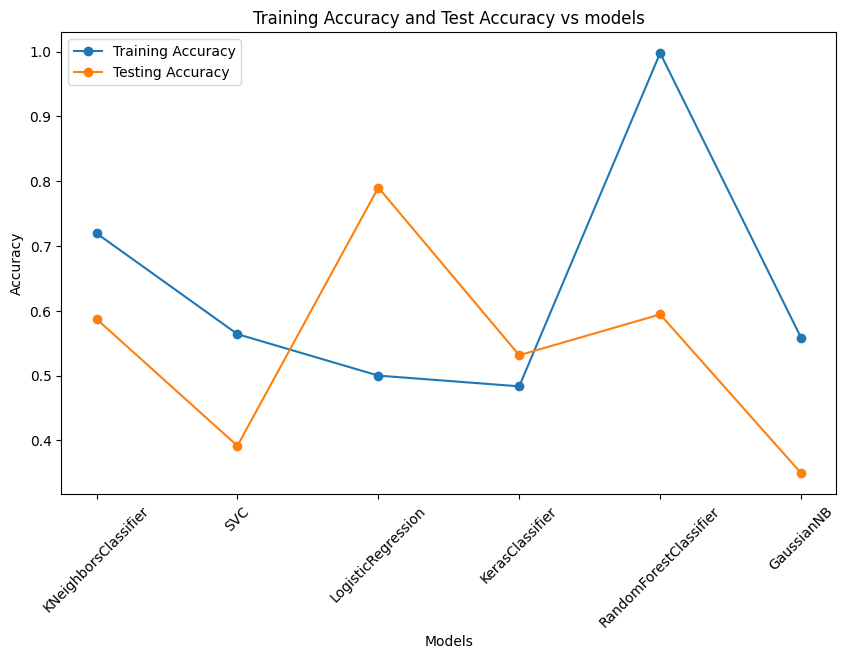

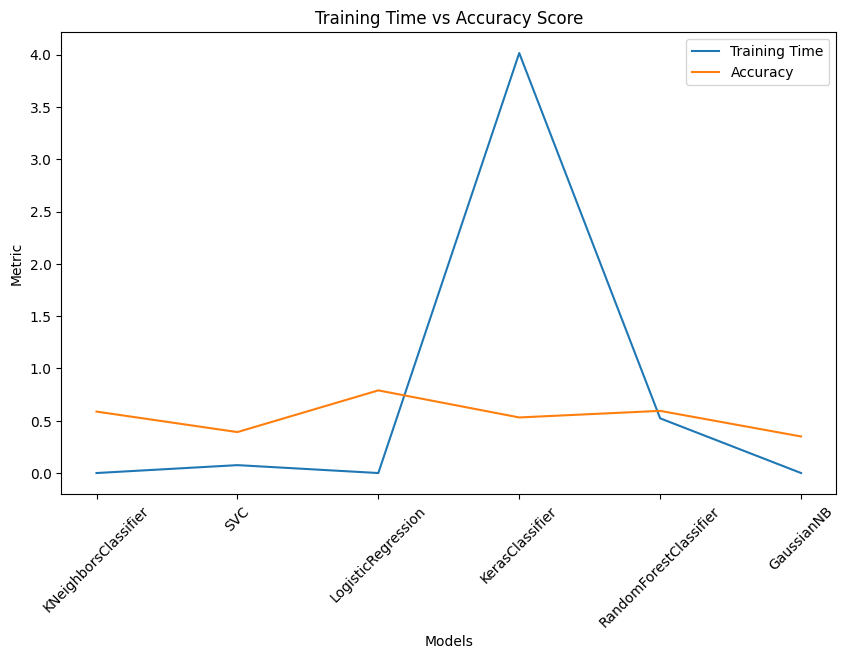

In [200]:
others_results, others_fit_check_plot, others_time_v_accuracy_plot, others_roc_plot = pipeline('others', others_params)

In [209]:
for model_result in others_results:
    print(f"{"="*15}{model_result['model'].__class__.__name__}{"="*15}")
    print(pd.DataFrame(model_result['conf_matrix'], index=["Actual Not Depressed", "Actual Depressed"], columns=["Pred Not Depressed", "Pred Depressed"]))
    print()

for model_result in others_results:
    print(f"{"="*15}{model_result['model'].__class__.__name__}{"="*15}")
    print(model_result['classification_report'])
    print()

===============KNeighborsClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                  68              45
Actual Depressed                      14              16

===============SVC===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                  46              67
Actual Depressed                      20              10

===============LogisticRegression===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                 113               0
Actual Depressed                      30               0

===============KerasClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed                  67              46
Actual Depressed                      21               9

===============RandomForestClassifier===============
                      Pred Not Depressed  Pred Depressed
Actual Not Depressed  

best model analysis:
- highest recall for depressed: knn
- highest AUC: knn
- highest precision for depressed: knn
- highest f1 for depressed: knn

recommendation: knn

In [210]:
dump_best_model('others', others_results[0]['model'], others_results[0]['scaler'])